In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from juliacall import Main as Main
import os

# Get the current working directory
current_dir = os.getcwd()
project_path = os.path.join(current_dir, "Code")

# Activate the Julia project
Main.seval(r'using Pkg; Pkg.activate("{}")'.format(project_path.replace("\\", r"\\")))
#Main.seval('using Pkg; Pkg.add("JLD2")')
Main.seval("using JLD2")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `c:\Users\Gloria\Github\Full-cost-balancing-\Code\Code`


### HPC results

##### Penalty check: conv. & time

In [2]:
data_pen = Main.seval('JLD2.load("export/export_HPC/penalty_test_all_folds_27537286.jld2", "data")')

A = np.vstack(data_pen["iter_bin"])      # shape: (n_rows, n_cols)
iter_bin_avg = A.mean(axis=1)
iter_bin_std = A.std(axis=1)
iter_bin_p25 = np.percentile(A, 25, axis=1)
iter_bin_p75 = np.percentile(A, 75, axis=1)

B = np.vstack(data_pen["iter_bin_LP"])
iter_bin_LP_avg = B.mean(axis=1)
iter_bin_LP_std = B.std(axis=1)

#find mix of data_pen["time_taken"] and iter_bin_avg that has the smallest smallest values of both
time_taken = np.array(data_pen["time_taken"])
x = np.array(data_pen["penalty"])



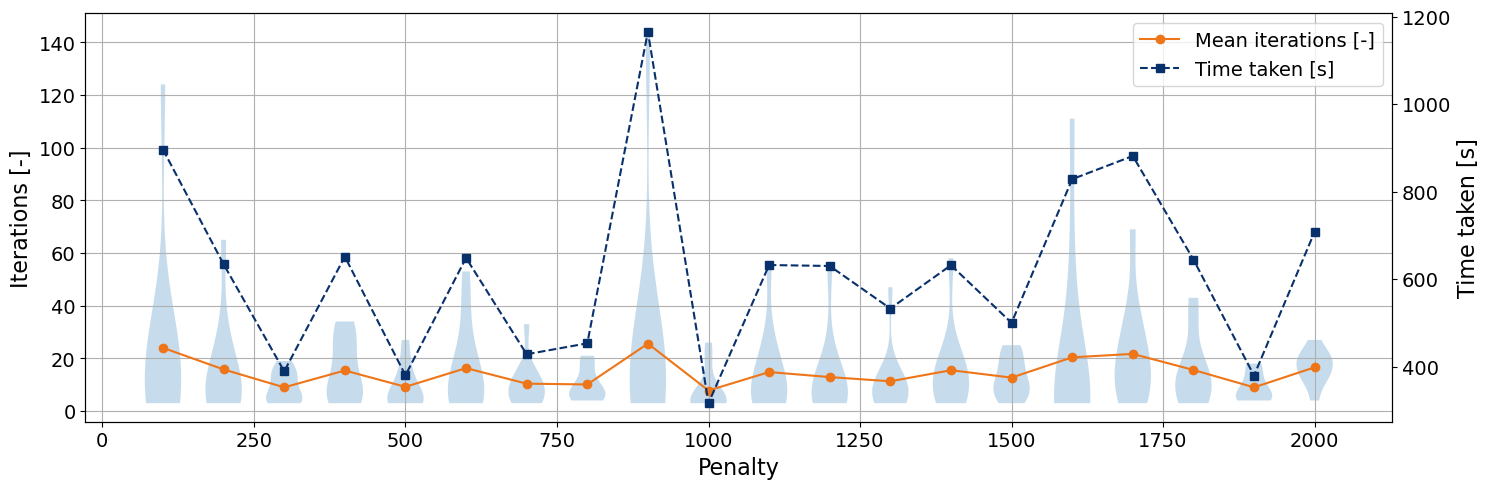

In [3]:

fig, ax1 = plt.subplots(figsize=(15, 5))

# violins expect a list of 1D arrays (one per x)
data = [A[i, :] for i in range(A.shape[0])]

vp = ax1.violinplot(
    data,
    positions=x,
    widths=60,          # adjust if penalties are spaced by 100
    showmeans=False,
    showmedians=False,
    showextrema=False
)

# make violins subtle
for body in vp["bodies"]:
    body.set_alpha(0.25)
    body.set_edgecolor("none")

# overlay summary lines
ax1.plot(x, iter_bin_avg, marker="o", label="Mean iterations [-]", color="#EE7518")

ax1.set_xlabel("Penalty", fontsize=16)
ax1.set_ylabel("Iterations [-]", fontsize=16)
ax1.grid(True)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

# second axis: time
ax2 = ax1.twinx()
ax2.plot(x, time_taken, marker="s", linestyle="--", label="Time taken [s]", color="#08306b")
ax2.set_ylabel("Time taken [s]", fontsize=16)
ax2.tick_params(axis="y", labelsize=14)

# combined legend (for both axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right", fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig("../Figures/Results/penalty_check.pdf")

#### Cf check ( change in Q)

In [4]:
Main.seval('data_Cf_9 = JLD2.load("export/export_HPC/Cf_9_results_27558151.jld2", "data")')
Main.seval('data_Cf_10 = JLD2.load("export/export_HPC/Cf_10_results_27558152.jld2", "data")')
Main.seval('data_Cf_11 = JLD2.load("export/export_HPC/Cf_11_results_27558153.jld2", "data")')
Main.seval('data_Cf_12 = JLD2.load("export/export_HPC/Cf_12_results_27558156.jld2", "data")')
Main.seval('data_Cf_5_8 = JLD2.load("export/export_HPC/Cf_sensitivity_results_27554239.jld2", "data")')

data_Cf_9 = Main.seval('data_Cf_9')
data_Cf_10 = Main.seval('data_Cf_10')
data_Cf_11 = Main.seval('data_Cf_11')
data_Cf_12 = Main.seval('data_Cf_12')
data_Cf_5_8 = Main.seval('data_Cf_5_8')

We can only test it for one fold for Cf>= 10. Have to exclude Cf== 9 from the testing 


#### Initial values check

In [5]:
data_init = Main.seval('JLD2.load("export/export_HPC/Init_val_results_27536529.jld2", "data")')

#### Big Q

In [6]:
Main.seval('data_bigQ = JLD2.load("export/export_HPC/Big_Q_27553825.jld2", "data")')

data_bigQ = Main.data_bigQ

### Computer results

In [7]:
# Load the file Base case and BigQ
Main.seval('data_BM = JLD2.load("export/data_BM.jld2", "data_BM")')
Main.seval('data_asy_BM = JLD2.load("export/data_asy_forecast_BM.jld2", "data_asy_forecast_BM")')
Main.seval('data_asy_GDCA = JLD2.load("export/data_asy_forecast_GDCA.jld2", "data_asy_forecast_GDCA")')
Main.seval('data_bin = JLD2.load("export/data_bin.jld2", "data_bin")')
Main.seval('R_bids = JLD2.load("export/reserve_bids.jld2", "R_bids")')
#Main.seval('data_bigQ = JLD2.load("export/data_bin_bigQ.jld2", "data_bin_bigQ")')

# Access it in Python
data_BM = Main.data_BM
data_asy_BM = Main.data_asy_BM
data_asy_GDCA = Main.data_asy_GDCA
data_bin = Main.data_bin

R_bids = Main.R_bids
rf_up = R_bids[0]
rf_down = R_bids[1]


Constants = np.load("export/Constants.npz")
q_up = Constants["q_up"]
q_down = Constants["q_down"]
NI_up = Constants["NI_up"]
NI_down = Constants["NI_down"]
Cp = Constants["Cp"]
Cf = Constants["Cf"]
Cr = Constants["Cr"]
Cf_Rup = Constants["Cf_Rup"]
Cf_Rdown = Constants["Cf_Rdown"]

nS_in_sample = len(data_BM["split_info"]["in_sample_Pw"][0][:, 0])
nS_out_sample = len(data_BM["split_info"]["out_sample_Pw"][0][:, 0])

In [8]:
data_asy_GDCA

Dict{Symbol, Dict{Symbol}} with 5 entries:
  :history    => Dict{Symbol, Vector}(:lambdas=>[(73, [73.0, 0.0, 73.0, 73.0, 7…
  :split_info => Dict{Symbol, Vector}(:in_sample_prob=>[[0.100259, 0.10295, 0.0…
  :profits    => Dict(:pol_out=>[[2438.85, 75.4178, -0.13396, -10.8601] [2437.4…
  :bids       => Dict{Symbol, Array}(:B_flex_down_in=>[0.0 0.0 … 0.0 0.0; 0.0 0…
  :aggregates => Dict(:mean_pol_bids_up_in=>[0.0; 0.0; … ; 0.0; 0.0;;], :pol_ou…

### Handling different Cf results

In [9]:
def nt_to_dict(x):
    """Recursively convert Julia NamedTuples (and structural arrays of them)
    to Python dicts, unwrapping singleton containers.
    """

    # Julia NamedTuple → dict
    if Main.isa(x, Main.NamedTuple):
        names = list(Main.propertynames(x))
        return {str(n): nt_to_dict(Main.getproperty(x, n)) for n in names}

    # Julia Tuple → Python tuple
    if Main.isa(x, Main.Tuple):
        return tuple(nt_to_dict(v) for v in list(x))

    # Julia Array
    if Main.isa(x, Main.AbstractArray):
        try:
            n = int(Main.length(x))
            if n == 0:
                return []

            # --- NEW: unwrap singleton containers more generally ---
            if n == 1:
                inner = x[0]

                # If singleton contains something "container-like", unwrap it
                # (this fixes Vector{Any}([ [..] ]) cases)
                if Main.isa(inner, Main.AbstractArray) or Main.isa(inner, Main.Tuple) or Main.isa(inner, Main.NamedTuple):
                    return nt_to_dict(inner)

                # If it's a Python list / sequence already, unwrap
                if hasattr(inner, "__len__") and not isinstance(inner, (str, bytes)):
                    return nt_to_dict(inner)

            first = x[0]

            # Structural array → convert elementwise
            if Main.isa(first, Main.NamedTuple) or Main.isa(first, Main.Tuple):
                converted = [nt_to_dict(v) for v in list(x)]
                return converted[0] if len(converted) == 1 else converted

        except Exception:
            pass

        # --- Optional but helpful: convert Julia numeric arrays to numpy ---
        # This makes them behave consistently in Python (vstack/mean/etc.)
        try:
            return np.array(x)
        except Exception:
            return x

    # Scalars / everything else
    return x


In [10]:
Main.seval('data_Cf_fold9 = JLD2.load("export/export_HPC/Cf_sens.jld2", "data")')
data_Cf_fold9 = Main.seval('data_Cf_fold9')

gdca_runs = data_Cf_fold9["GDCA"]   # Vector{NamedTuple}
BM_runs = data_Cf_fold9["BM"]     # Vector{NamedTuple}
R_Cf_GDCA = {}
R_Cf_BM = {}
for i in range(len(gdca_runs)):             # Python 0..n-1
    if Main.isassigned(gdca_runs, i+1):     # Julia 1..n
        R_Cf_GDCA[i+1] = nt_to_dict(gdca_runs[i])  # key is the ORIGINAL slot number
        R_Cf_BM[i+1] = nt_to_dict(BM_runs[i])  # key is the ORIGINAL slot number

sorted(R_Cf_GDCA.keys())

[1, 2, 3, 4, 5, 6]

In [11]:
gdca_runs

6-element Vector{Any}:
 (profits = (pol_in = [[2450.21, 113.48744601412722, -0.0, -9.240890540650039]; [2450.21, 113.48744601412722, -0.0, -9.240890540650039]; … ; [3782.5699999999997, 174.73541271443, -0.0, -14.702600882156236]; [3782.5699999999997, 174.73541271443, -0.0, -14.702600882156236];;], flex_in = [[-0.0, -0.0, 0.0]; [-0.0, -0.0, 0.0]; … ; [0.0, 0.0, 50.0]; [0.0, 0.0, 50.0];;], reg_in = [[-0.0]; [-0.0]; [2400.0];;], pol_out = [[2450.21, 56.29795058220217, -9.577151451401098, -6.426760331479124]; [2450.21, 56.29795058220217, -9.577151451401098, -6.426760331479124]; … ; [3782.5699999999997, 86.63573027783646, -15.406290848248428, -10.246529415327737]; [3782.5699999999997, 86.63573027783646, -15.406290848248428, -10.246529415327737];;], flex_out = [[-0.0, -0.0, 0.0]; [-0.0, -0.0, 0.0]; … ; [0.0, 0.0, 50.0]; [0.0, 0.0, 50.0];;], reg_out = [[-0.0]; [-0.0]; [2400.0];;], pol_out_ind = [[2450.21, 56.29795058220217, -9.577151451400812, -6.426760331479238]; [2450.21, 56.29795058220217,

### Loading the plotting library 

In [12]:
#include python file plotting_functions.py 
import importlib, plotting_functions as pf
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

#### Values

In [13]:
markets_d = ["Day-ahead", "Balancing", "Procurement Cost"]
markets_f = ["Day-ahead", "Balancing", "Reserve"]
markets_bl = ["Day-ahead"]

model_names = ["Benchmark", "FCB"]

#Deviators = [f"W_On_good{i}" for i in range(1, 3)] +[f"W_On_mid{i}" for i in range(1, 3)] +[f"W_On_bad{i}" for i in range(1, 3)]  + [f"W_Off_good{i}" for i in range(1, 3)] +[f"W_Off_mid{i}" for i in range(1, 3)] +[f"W_Off_bad{i}" for i in range(1, 3)] 
Deviators = (
    [rf"On{i}$_{{\gamma = 0.05}}$"  for i in range(1, 3)] +
    [rf"On{i}$_{{\gamma = 0.125}}$" for i in range(1, 3)] +
    [rf"On{i}$_{{\gamma = 0.25}}$"  for i in range(1, 3)] +
    [rf"Off{i}$_{{\gamma = 0.05}}$" for i in range(1, 3)] +
    [rf"Off{i}$_{{\gamma = 0.125}}$"for i in range(1, 3)] +
    [rf"Off{i}$_{{\gamma = 0.25}}$" for i in range(1, 3)]
)

Flexibles = [f"SCGT{i}" for i in range(1, 5)] + [ f"CCGT{i}" for i in range(1,5)] # Example names for 5 flexibles
Base_loads= ["Biomass", "Coal", "Waste"] 
nP = len(Deviators)
nF = len(Flexibles)
nR = len(Base_loads)
grad = cm.viridis  # or any colormap
bar_colors = [grad(i/(nP-1)) for i in range(nP)]

tech_by_type = {
    "Deviators":  ["Onshore", "Offshore"],
    "Flexibles":  ["SCGT", "CCGT"],
    "Base loads": ["Biomass", "Coal", "Waste"],
}


names_by_type = {
    "Deviators": Deviators,
    "Flexibles": Flexibles,
    "Base loads": Base_loads,
}

model_names_Cf =[f"Q$_{{{i}}}$" for i in range(1, 3)] + ["Q$_{FCB}$"] + [f"Q$_{{{i}}}$" for i in range(4, 5)] +  [f"Q$_{{{i}}}$" for i in range(7, 8)] 

Forecast Asymmetry

In [14]:
DA_bids = {
    "FCB":{
        "Deviators": data_bin["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_bin["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_bin["aggregates"]["mean_reg_DA_bids_out"]
    },

    "FCB_assymetric": {
        "Deviators": data_asy_GDCA["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_asy_GDCA["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_asy_GDCA["aggregates"]["mean_reg_DA_bids_out"]
    },
}

DA_bids_pol = {
    "Benchmark": {
        "polluters": data_BM["aggregates"]["mean_pol_DA_bids_out"]
    },
    "FCB": {
        "polluters": data_asy_GDCA["aggregates"]["mean_pol_DA_bids_out"]
    },
}

run_to_Q = {
    1: 1,
    2: 2,
    4: 4,
    5: 7
}
FCB_run = 3

def make_entry(idx):
    print(idx)
    agg = R_Cf_GDCA[idx]["aggregates"]
    return {
        "Deviators":  agg["mean_pol_DA_bids_out"],
        "Flexibles":  agg["mean_flex_DA_bids_out"],
        "Base loads": agg["mean_reg_DA_bids_out"],
    }

order = [1, 2, "FCB", 4, 7]

# invert mapping: Q -> run_idx
Q_to_run = {Q: run for run, Q in run_to_Q.items()}

DA_bids_Q = {}
for item in order:
    if item == "FCB":
        DA_bids_Q["Q$_{FCB}$"] = make_entry(FCB_run)
    else:
        print(Q_to_run[item])
        DA_bids_Q[f"Q$_{item}$"] = make_entry(Q_to_run[item])



1
1
2
2
3
4
4
5
5


In [15]:
type_colors = {
    "Deviators":  "#EE7518",  # Muted orange
    "Flexibles":  "#08306b",  # Blue-teal
    "Base loads": "#2E8B57",  # Green
}

# Use this for a more professional, cohesive look
tech_colors = {
    "On_0.05":  "#EE7518",  # good
    "On_0.125": "#C85700",  # mid
    "On_0.25":  "#EA985A",  # bad
    "Off_0.05": "#EE6318",  # good
    "Off_0.125":"#A33B03",  # mid
    "Off_0.25": "#893406",  # bad
    "SCGT":     "#3f8fc4", # Deep Night Teal (From your preferred set)
    "CCGT":     "#08306b",  # Blue-teal
    "Extra_blue": "#2257a5", # Dark Blue
    "Biomass":  "#4CCA53",  # Green
    "Coal":     "#2E6F40",  # Dark green
    "Waste":    "#388E3C", # Forest Green (The "Waste" green you need)
}


bar_color = type_colors["Flexibles"]  # "#08306b"
AllTechs = Deviators + Flexibles + Base_loads



In [16]:
deviations_list = [
    np.asarray(data_bin["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_asy_GDCA["aggregates"]["mean_pol_bids_out"]).ravel()]

deviations_up_list = [
    np.asarray(data_bin["aggregates"]["mean_pol_bids_up_out"]).ravel(), 
    np.asarray(data_asy_GDCA["aggregates"]["mean_pol_bids_up_out"]).ravel()
    ]   # nP x 1 or nP

deviations_down_list = [
    np.asarray(data_bin["aggregates"]["mean_pol_bids_down_out"]).ravel(), 
    np.asarray(data_asy_GDCA["aggregates"]["mean_pol_bids_down_out"]).ravel()
    ]

dev_all_list = [
    np.asarray(data_bin["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_asy_GDCA["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_bin["aggregates"]["mean_flex_bids_up_out"]).ravel(),
    np.asarray(data_asy_GDCA["aggregates"]["mean_flex_bids_up_out"]).ravel(),
]

#deviations for rhe runs
dev_Q_list = (
    [np.asarray(data_bin["aggregates"]["mean_pol_bids_in"]).ravel()]
    + [
        np.asarray(R_Cf_GDCA[r]["aggregates"]["mean_pol_bids_in"]).ravel()
        for r in sorted(R_Cf_GDCA.keys())
    ]
)

In [17]:
pBIN_list = [
    data_bin["aggregates"]["pol_out_avg"], 
    data_asy_GDCA["aggregates"]["pol_out_avg"]
]#, data_bin_bigQ["aggregates"]["pol_out_avg"]]  # nP x ≥4 arrays


#profits for stacking plot per generator type
#Deviators
# sum columns 2 and 3 (zero-indexed)
pBM_dev = np.column_stack([data_bin["aggregates"]["pol_out_avg"][:, 0], data_bin["aggregates"]["pol_out_avg"][:, 1], data_bin["aggregates"]["pol_out_avg"][:, 2] + data_bin["aggregates"]["pol_out_avg"][:, 3]])
pBIN_dev = np.column_stack([data_asy_GDCA["aggregates"]["pol_out_avg"][:, 0], data_asy_GDCA["aggregates"]["pol_out_avg"][:, 1], data_asy_GDCA["aggregates"]["pol_out_avg"][:, 2] + data_asy_GDCA["aggregates"]["pol_out_avg"][:, 3]])
#pBIN_bigQ_dev = np.column_stack([data_bin_bigQ["aggregates"]["pol_out_avg"][:, 0], data_bin_bigQ["aggregates"]["pol_out_avg"][:, 1], data_bin_bigQ["aggregates"]["pol_out_avg"][:, 2] + data_bin_bigQ["aggregates"]["pol_out_avg"][:, 3]])


#Flexibles
# sum columns 2 and 3 (zero-indexed)
pBM_flex = np.column_stack([data_asy_BM["aggregates"]["flex_out_avg"][:, 0], data_asy_BM["aggregates"]["flex_out_avg"][:, 1], data_asy_BM["aggregates"]["flex_out_avg"][:, 2] ])
pBIN_flex = np.column_stack([data_asy_GDCA["aggregates"]["flex_out_avg"][:, 0], data_asy_GDCA["aggregates"]["flex_out_avg"][:, 1], data_asy_GDCA["aggregates"]["flex_out_avg"][:, 2] ])
#pBIN_bigQ_flex = np.column_stack([data_bin_bigQ["aggregates"]["flex_out_avg"][:, 0], data_bin_bigQ["aggregates"]["flex_out_avg"][:, 1], data_bin_bigQ["aggregates"]["flex_out_avg"][:, 2]])
   

#Base loads
pBM_base = np.column_stack([data_asy_BM["aggregates"]["reg_out_avg"][:, 0]])
pBIN_base = np.column_stack([data_asy_GDCA["aggregates"]["reg_out_avg"][:, 0]])
#pBIN_bigQ_base = np.column_stack([data_bin_bigQ["aggregates"]["reg_out_avg"][:, 0]])


In [18]:
Q_up_list = [q_up, q_up]#, q_up + q_down, q_up, q_up + q_down]
Q_down_list = [q_down, q_down]#, q_down + q_up, q_down, q_down + q_up]

In [19]:
system_imbalance_bin = data_asy_GDCA["history"]["system_imbalance"]
system_imbalance_BM = data_asy_BM["history"]["system_imbalance"]

 #how to call on them 
SI_up_in   = [t[0][0] for t in system_imbalance_BM]    
SI_down_in = [t[0][1] for t in system_imbalance_BM]
SI_none_in = [t[0][2] for t in system_imbalance_BM]

SI_up_out   = [t[1][0] for t in system_imbalance_bin]
SI_down_out = [t[1][1] for t in system_imbalance_bin]
SI_none_out = [t[1][2] for t in system_imbalance_bin]

(<Figure size 1000x800 with 1 Axes>, <Figure size 1000x800 with 1 Axes>)

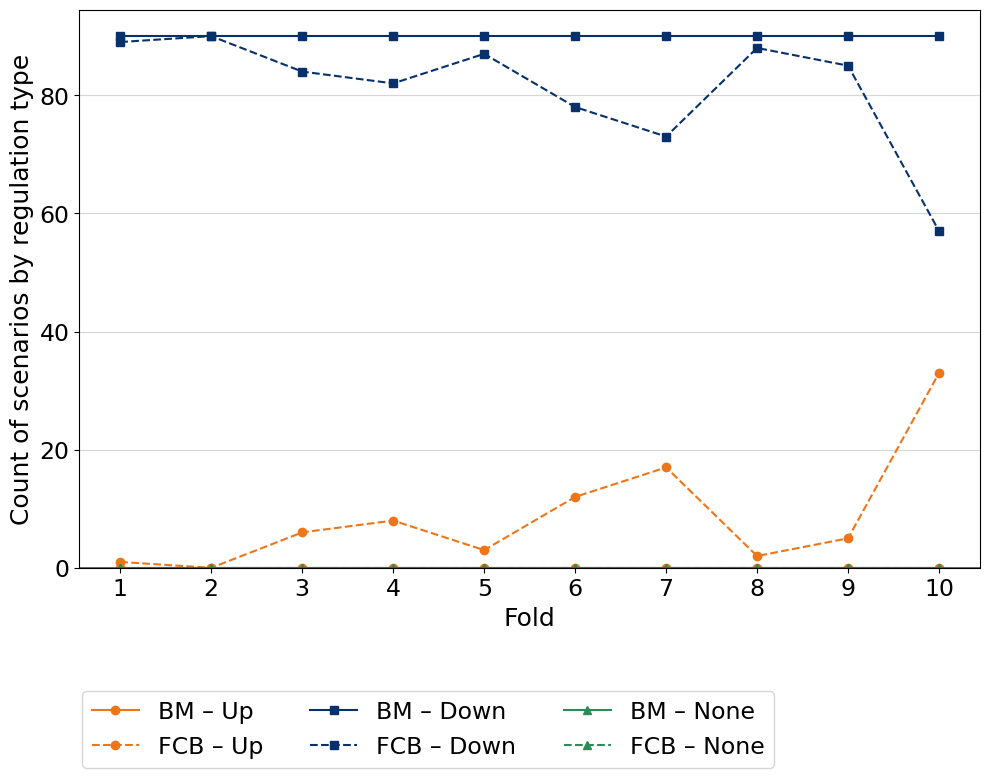

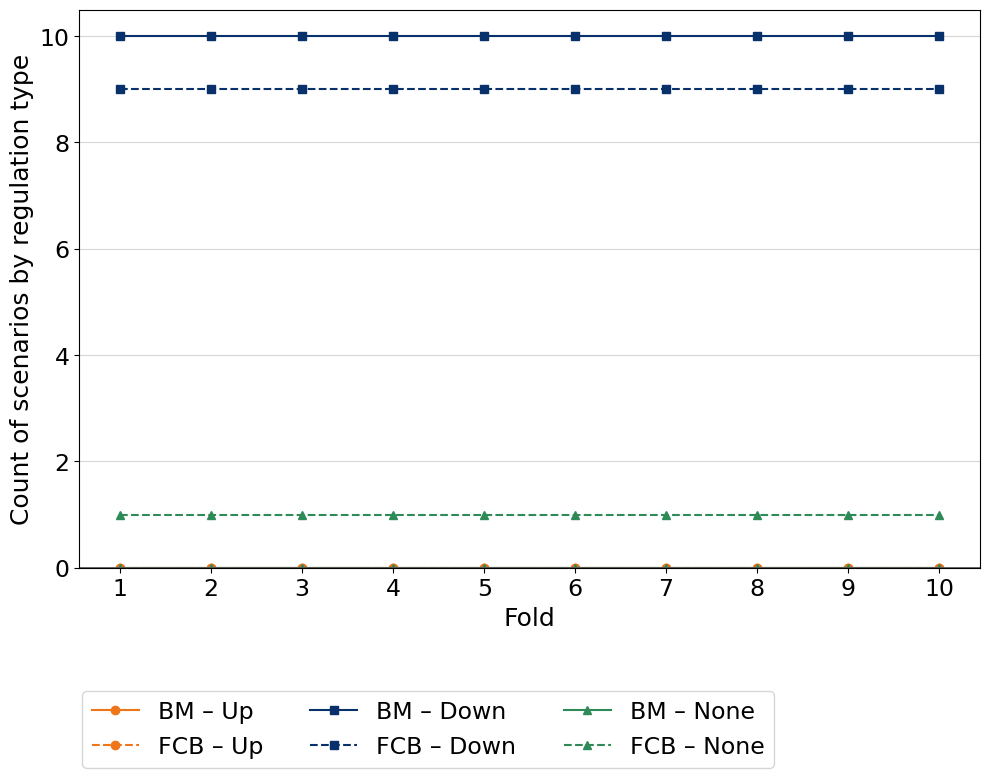

In [20]:
pf.plot_SI_in_out_BM_vs_BIN_one_axes(
    system_imbalance_BM=system_imbalance_BM,
    system_imbalance_BIN=system_imbalance_bin,
    component_names=("Up", "Down", "None"),
    tol=1e-6,   # use your tolerance
    legend_anchor=(-0.01, -0.2), # as you requested
    legend_ncol=3,
)

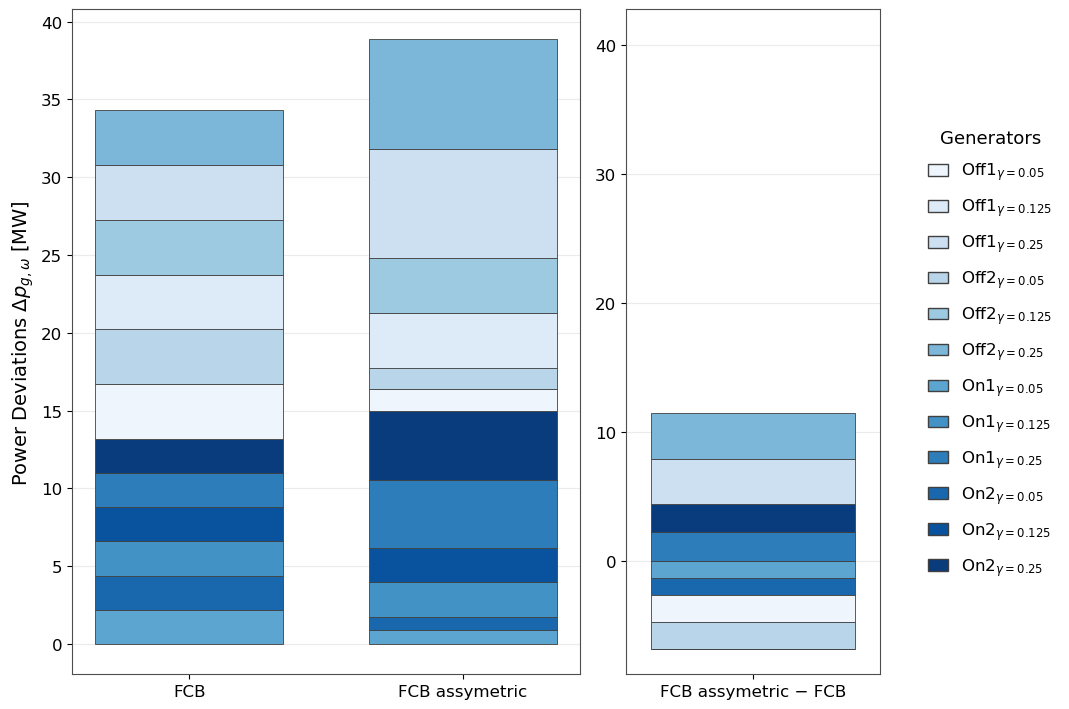

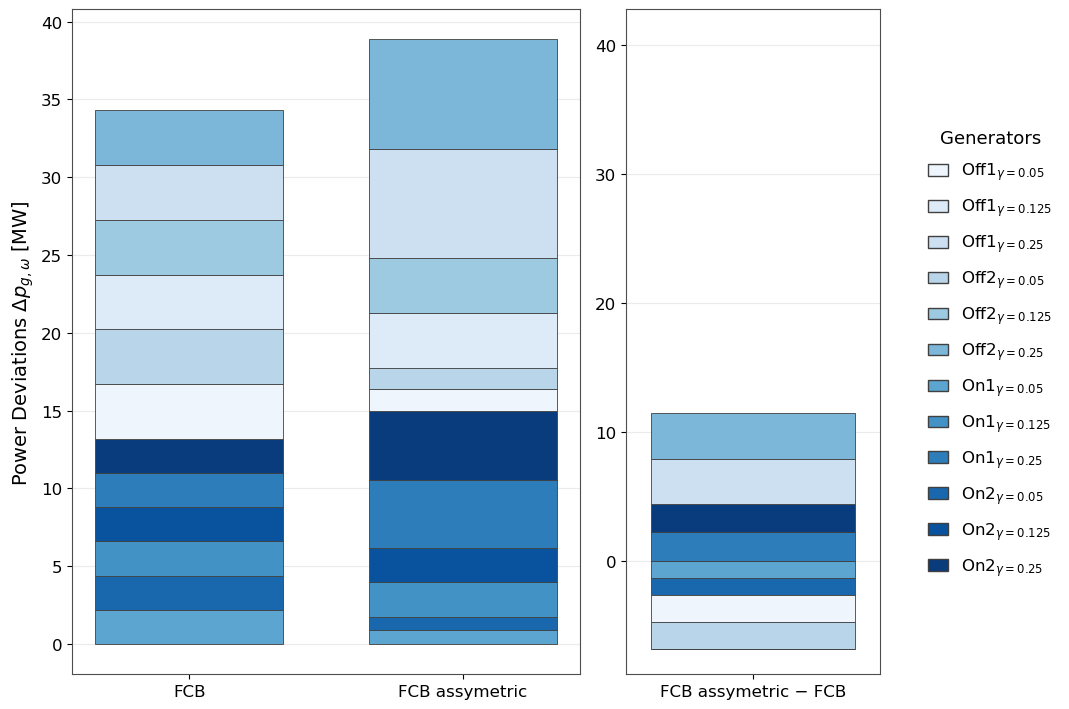

In [21]:
model_names = ["FCB", "FCB assymetric"]
pf.plot_power_deviations_models(model_names, deviations_list, Deviators, show_arrows= False)

In [48]:
#include python file plotting_functions.py 
import importlib, plotting_functions as pf
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

['On1$_{\\gamma = 0.05}$', 'On2$_{\\gamma = 0.05}$', 'On1$_{\\gamma = 0.125}$', 'On2$_{\\gamma = 0.125}$', 'On1$_{\\gamma = 0.25}$', 'On2$_{\\gamma = 0.25}$', 'Off1$_{\\gamma = 0.05}$', 'Off2$_{\\gamma = 0.05}$', 'Off1$_{\\gamma = 0.125}$', 'Off2$_{\\gamma = 0.125}$', 'Off1$_{\\gamma = 0.25}$', 'Off2$_{\\gamma = 0.25}$']
['SCGT1', 'SCGT2', 'SCGT3', 'SCGT4', 'CCGT1', 'CCGT2', 'CCGT3', 'CCGT4']
['Biomass', 'Coal', 'Waste']


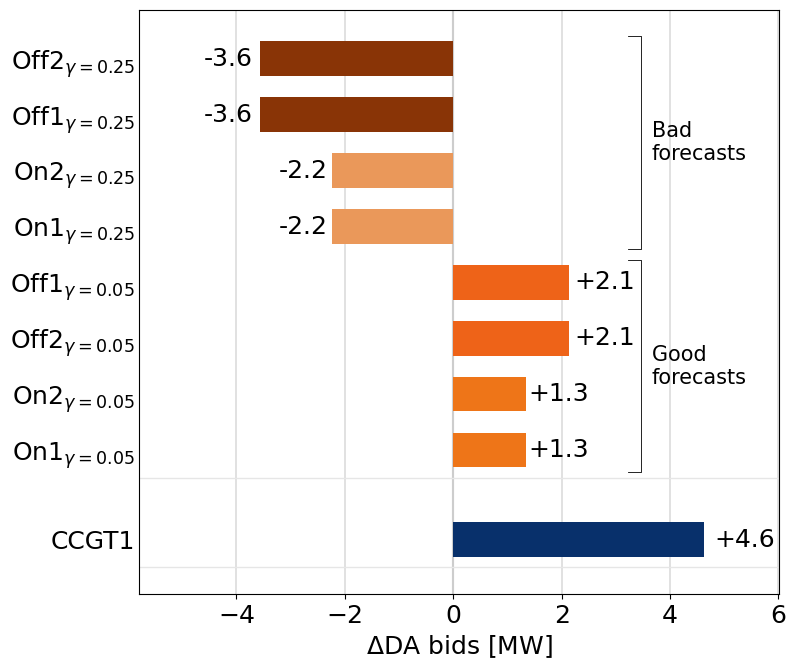

In [49]:
bar_color = type_colors["Flexibles"]  # "#08306b"
DA_bids_FCB ={
    "FCB": {
        "Deviators": data_bin["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_bin["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_bin["aggregates"]["mean_reg_DA_bids_out"]
    },
    "FCB_assymetric": {
        "Deviators": data_asy_GDCA["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_asy_GDCA["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_asy_GDCA["aggregates"]["mean_reg_DA_bids_out"]
    },
}

diff_DA_fig = pf.plot_DA_bid_difference_one_color_from_nested_dict(
    DA_bids=DA_bids_FCB,
    generators_by_type=names_by_type,
    model_names=( "FCB", "FCB_assymetric"),
    tech_colors=tech_colors,
    sort_by="abs", asy = True,
    figsize=(10, 8), 
    title = "",
    fontsize = 18
)
diff_DA_fig.savefig("../Figures/Results/diff_DA_fig_asy.pdf")


In [87]:
def costs_per_fold(fold, nS, nP, nF, nR, prob_all, DA_bids, B_bids_pol, B_pol_expected, 
                   B_bids_flex, R_bids, Cf_Rup, Cf_Rdown, Q_up=None, Q_down=None, tol=1e-6):
    # This is for 1 fold
    # B_bids corresponds to the up [0] and down [0] bids that are contributing to the system imbalance
    pol_cost = [None] * nP
    flex_cost = [None] * nF
    reg_cost = [None] * nR

    include_penalty = Q_up is not None and Q_down is not None
    prob = prob_all[fold]
    
    k_up = np.zeros((nS, nP))
    k_down = np.zeros((nS, nP))

    # --- imbalance shares ---
    for w in range(nS):
        total_imbalance = np.sum(B_bids_pol[fold][0][w, :]) + np.sum(B_bids_pol[fold][1][w, :]) # SUM OF UP AND DOWN REGULATION DEVIATIONS FOR THIS SCENARIO
        z_down = np.sum(B_bids_pol[fold][1][w, :]) # DOWN REGULATION
        z_up = np.sum(B_bids_pol[fold][0][w, :])  # UP REGULATION

        for p in range(nP):
            bid_up = B_bids_pol[fold][0][w, p]
            bid_down = B_bids_pol[fold][1][w, p]

            if total_imbalance > tol and bid_down > 0:
                k_down[w, p] = bid_down / z_down
            elif total_imbalance < -tol and bid_up < 0:
                k_up[w, p] = bid_up / z_up

    # --- polluters ---
    for p in range(nP):
        cost_DA = DA_bids[fold][0][p] * Cp[p]
        cost_B = Cp[p]*B_pol_expected[p, fold]
        penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
        penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0

        pol_cost[p] = [cost_DA, cost_B, penalty_up, penalty_down]


    # --- flexible units ---
    for f in range(nF):
        cost_DA = DA_bids[fold][1][f] * Cf[f]
        cost_B = Cf[f] * (B_bids_flex[0][f, fold] - B_bids_flex[1][f, fold])               # IT SHOULD BE FIRST UP [0] THEN  DOWN [0] BUT THE VALUES ARE SWAPPED FOR NOW
        cost_R = (
            R_bids[0][f] * Cf_Rup[f]
            + R_bids[1][f] * Cf_Rdown[f])
        cost_R = 0
        flex_cost[f] = [cost_DA, cost_B, cost_R]

    # --- regular generators ---
    for r in range(nR):
        cost_DA = DA_bids[fold][2][r] * Cr[r]
        reg_cost[r] = [cost_DA]

    return pol_cost, flex_cost, reg_cost


In [88]:
systems_costs_BM_in = []
systems_costs_BM_out = []
systems_costs_FCB_in =[]
systems_costs_FCB_out =[]

prob_insample = data_asy_GDCA["split_info"]["in_sample_prob"]
prob_outsample = data_asy_GDCA["split_info"]["out_sample_prob"]

for fold in range (10):
    flex_bids_insample = [data_asy_GDCA["bids"]["B_flex_up_in"], data_asy_GDCA["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_asy_GDCA["bids"]["DA_bids_insample"], data_asy_GDCA["bids"]["B_bids_all_insample"], data_asy_GDCA["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_BM_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_asy_GDCA["bids"]["B_flex_up_out"], data_asy_GDCA["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_asy_GDCA["bids"]["DA_bids_outsample"], data_asy_GDCA["bids"]["B_bids_all_outsample"], data_asy_GDCA["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_BM_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_insample = [data_bin["bids"]["B_flex_up_in"], data_bin["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_bin["bids"]["DA_bids_insample"], data_bin["bids"]["B_bids_all_insample"], data_bin["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_FCB_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_bin["bids"]["B_flex_up_out"], data_bin["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_bin["bids"]["DA_bids_outsample"], data_bin["bids"]["B_bids_all_outsample"], data_bin["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_FCB_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

C:\Users\Gloria\AppData\Local\Temp\ipykernel_720\1696805136.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
C:\Users\Gloria\AppData\Local\Temp\ipykernel_720\1696805136.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0


In [89]:
def split_costs(system_costs):
    pol  = [np.sum(c["pol"])  for c in system_costs]
    flex = [np.sum(c["flex"]) for c in system_costs]
    reg  = [np.sum(c["reg"])  for c in system_costs]
    nP = len(system_costs[0]['pol'])
    tot = [np.sum(c["reg"]) + np.sum(c["flex"]) + np.sum(c["pol"]) for c in system_costs]
    procurement_cost_up = [np.sum([c['pol'][p][2] for p in range(nP)]) for c in system_costs]
    procurement_cost_down = [np.sum([c['pol'][p][3] for p in range(nP)]) for c in system_costs]

    return np.array(pol), np.array(flex), np.array(reg), np.array(tot), np.array(procurement_cost_up), np.array(procurement_cost_down)

def systems_costs(system_costs_BM_in, system_costs_BM_out, system_costs_FCB_in, system_costs_FCB_out, figsize = (10, 8), fontsize = 18):
    BM_in  = split_costs(system_costs_BM_in)
    BM_out = split_costs(system_costs_BM_out)
    FCB_in  = split_costs(system_costs_FCB_in)
    FCB_out = split_costs(system_costs_FCB_out)

    components = ["Deviators", "Flexible", "Base Loads", "Total"]
    n_folds = len(BM_in[0])  # assuming BM_in[i] is length n_folds

    x = np.arange(len(components))

    fig = plt.figure(figsize=figsize)

    for i, comp in enumerate(components):
        # In-sample
        y_in = (np.array(FCB_in[i]) - np.array(BM_in[i]))/np.array(BM_in[i])*100
        plt.scatter(np.full(n_folds, x[i]-0.1), 
                    y_in, color='#08306b', alpha=0.6, label='In-sample' if i==0 else "")
        # Out-of-sample
        y_out = (np.array(FCB_out[i]) - np.array(BM_out[i]))/np.array(BM_out[i])*100
        plt.scatter(np.full(n_folds, x[i]+0.1), 
                    y_out, color='#EE7518', alpha=0.6, label='Out-of-sample' if i==0 else "")
    
    # Optional: mean markers
    for i in range(4):
        plt.plot(x[i]-0.1, np.mean((np.array(FCB_in[i]) - np.array(BM_in[i]))/np.array(BM_in[i]))*100, 'o', color='#08306b', markersize=10)
        plt.plot(x[i]+0.1, np.mean((np.array(FCB_out[i]) - np.array(BM_out[i]))/np.array(BM_out[i]))*100, 'o', color='#EE7518', markersize=10)
    
    print("total diff in : ", np.mean(np.array(FCB_in[0]) - np.array(BM_in[0])))
    print("total diff out: ", np.mean(np.array(FCB_out[0]) - np.array(BM_out[0])))

    penalty_in = np.mean((np.array(FCB_in[0]) - np.array(BM_in[0]))/np.array(BM_in[0]))*100
    penalty_out = np.mean((np.array(FCB_out[0]) - np.array(BM_out[0]))/np.array(BM_out[0]))*100
    penalty_up = penalty_out - penalty_in

    penalty_down_in = np.mean(np.array(FCB_in[5]) - np.array(BM_in[5]))
    penalty_down_out = np.mean(np.array(FCB_out[5]) - np.array(BM_out[5]))

    penalty_up_2 = np.mean(np.array(FCB_out[4]) - np.array(BM_out[4]))
                           


    plt.xticks(x, components, rotation = 45)
    plt.ylabel(rf"$\Delta$ System Costs (FCB − BM) [%]", fontsize = fontsize)
    plt.axhline(0, color='black', linestyle='--', lw=1)
    plt.legend(fontsize = fontsize, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.margins(0.2, 0.2)
    return fig


total diff in :  0.20567613294010698
total diff out:  0.22288658865227262


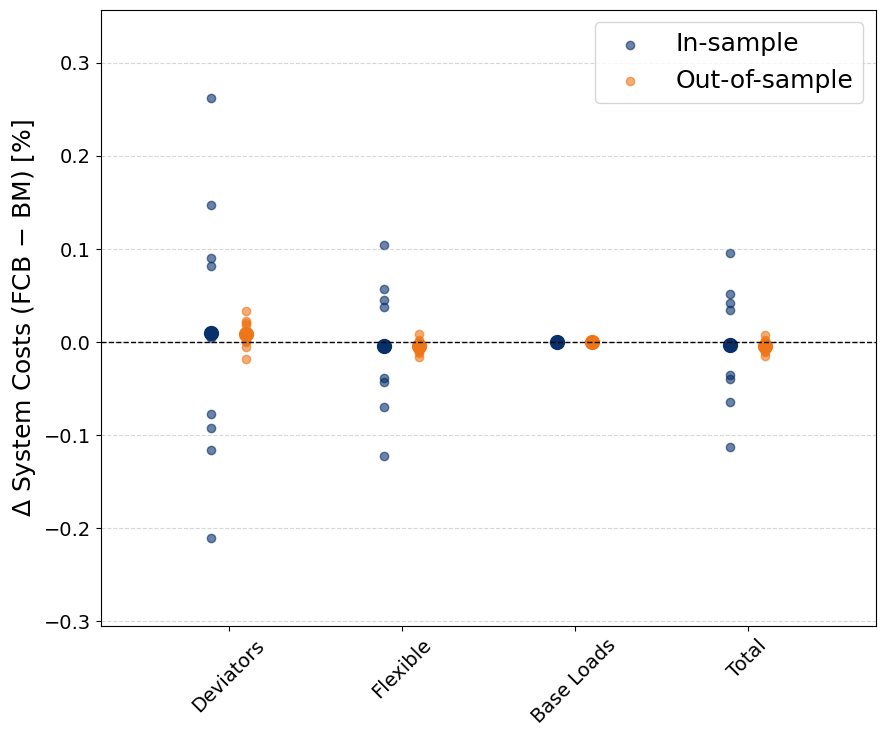

In [90]:
fig_systems_costs = systems_costs(systems_costs_BM_in, systems_costs_BM_out, systems_costs_FCB_in, systems_costs_FCB_out)

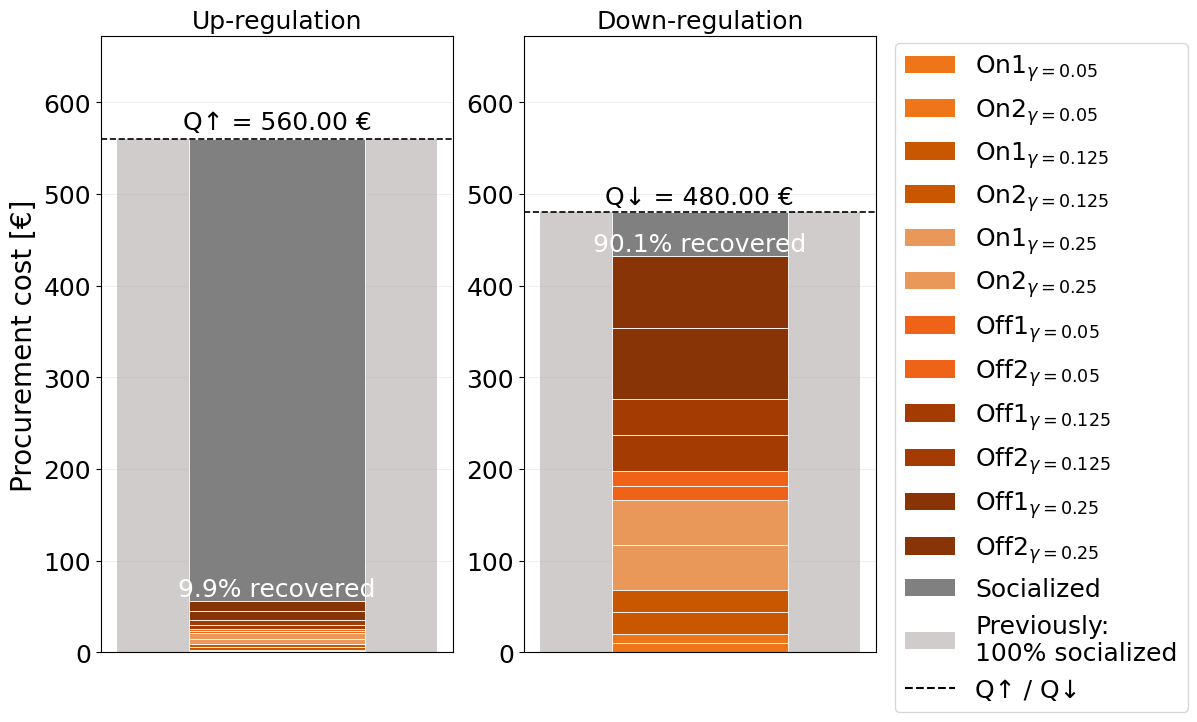

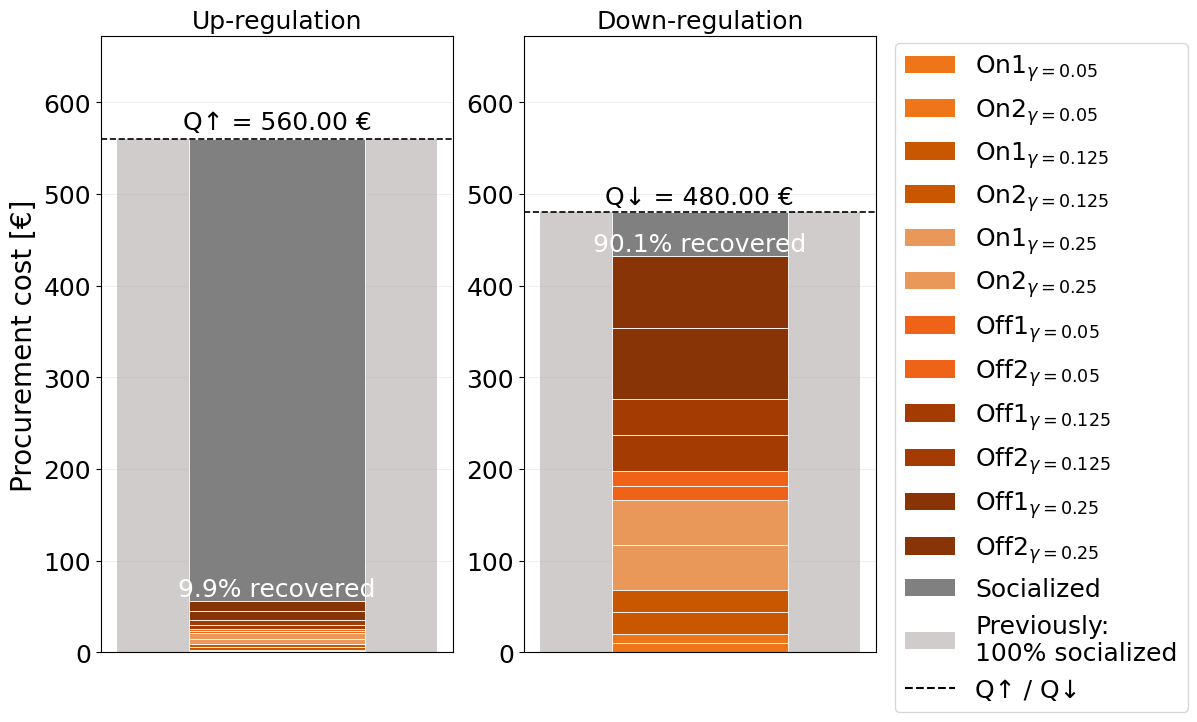

In [91]:
pf.plot_socialized_vs_individualized_FCB_only(
    pBIN_fcb=pBIN_list[1],      # assuming index 1 is FCB
    Q_up=Q_up_list[1],
    Q_down=Q_down_list[1],
    tech_colors=tech_colors,
    polluters=Deviators, 
    figsize=(10, 8),
    prev_social_color="#d0cccc",
    asy = True
)

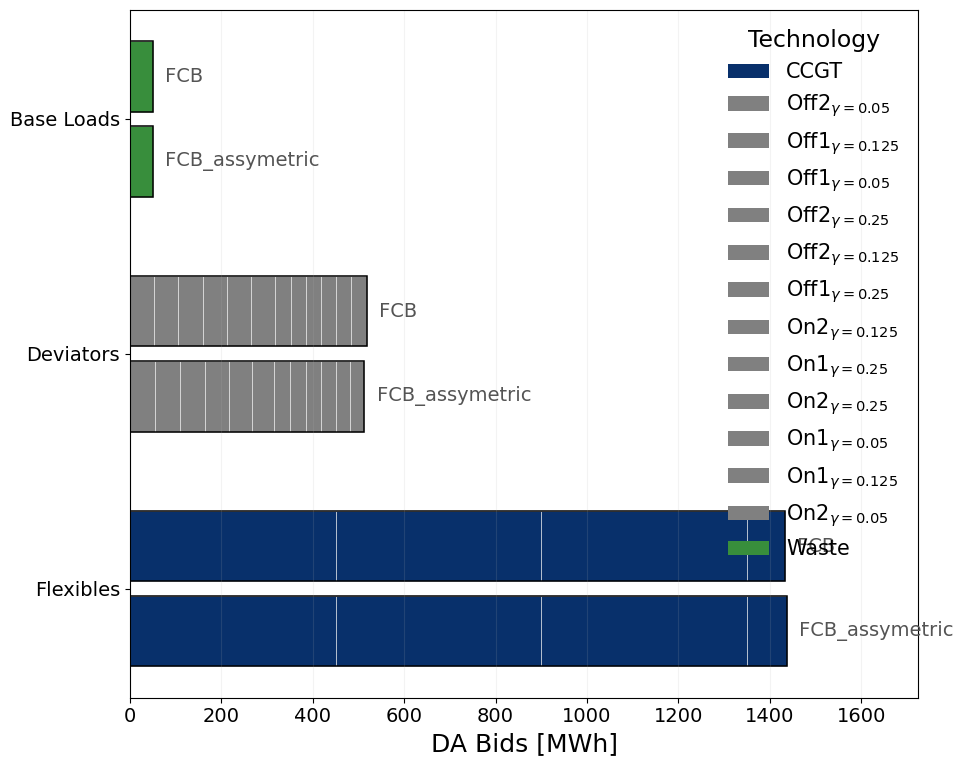

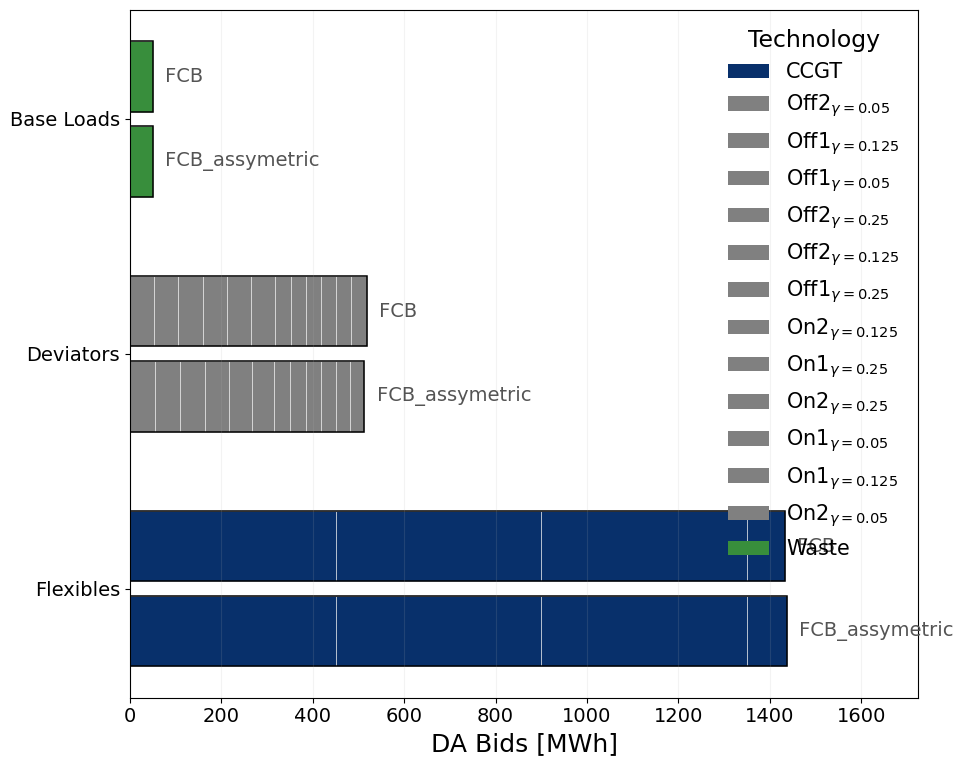

In [92]:
pf.plot_DA_bids_transposed_models_by_type_generators(
    DA_bids,
    types_to_plot=["Deviators", "Flexibles", "Base loads"],
    names_by_type=names_by_type,
    tech_colors=tech_colors,
    base_fontsize=18,
    tick_fontsize=14,
    legend_fontsize=15,
    sep_lw = 0.4,
    sep_color = "#f2f2f2"   # very light gray instead of white

)


In [93]:
profits_pol_in = data_asy_GDCA["profits"]["pol_in"]
profits_pol_out = data_asy_GDCA["profits"]["pol_out"]

# 1. Extract Penalty Up (3rd element in Julia)
Main.profits_matrix_in = profits_pol_in
penalty_up_in = Main.seval("""
    map(profits_matrix_in) do v
        # If v is a vector [p1, p2, p3, p4], grab index 3
        (v isa AbstractVector && length(v) >= 3) ? v[3] : 0.0
    end
""")

# 2. Extract Penalty Down (4th element in Julia)
penalty_down_in = Main.seval("""
    map(profits_matrix_in) do v
        (v isa AbstractVector && length(v) >= 4) ? v[4] : 0.0
    end
""")

# Repeat for Out-Sample
Main.profits_matrix_out = profits_pol_out
penalty_up_out = Main.seval("map(v -> (v isa AbstractVector && length(v) >= 3) ? v[3] : 0.0, profits_matrix_out)")
penalty_down_out = Main.seval("map(v -> (v isa AbstractVector && length(v) >= 4) ? v[4] : 0.0, profits_matrix_out)")


In [94]:
def collapse_pairs(matrix):
    """
    matrix: 12 x N
    returns: 6 x N
    """
    matrix = np.asarray(matrix)
    return np.vstack([
        matrix[0:2].mean(axis=0),
        matrix[2:4].mean(axis=0),
        matrix[4:6].mean(axis=0),
        matrix[6:8].mean(axis=0),
        matrix[8:10].mean(axis=0),
        matrix[10:12].mean(axis=0),
    ])

up_in_c   = collapse_pairs(penalty_up_in)
up_out_c  = collapse_pairs(penalty_up_out)
down_in_c = collapse_pairs(penalty_down_in)
down_out_c= collapse_pairs(penalty_down_out)

Deviators_collapsed = [
    r'On$1-2_{\gamma=0.05}$',
    r'On$1-2_{\gamma=0.125}$',
    r'On$1-2_{\gamma=0.25}$',
    r'Off$1-2_{\gamma=0.05}$',
    r'Of$1-2_{\gamma=0.125}$',
    r'Off$1-2_{\gamma=0.25}$',
]

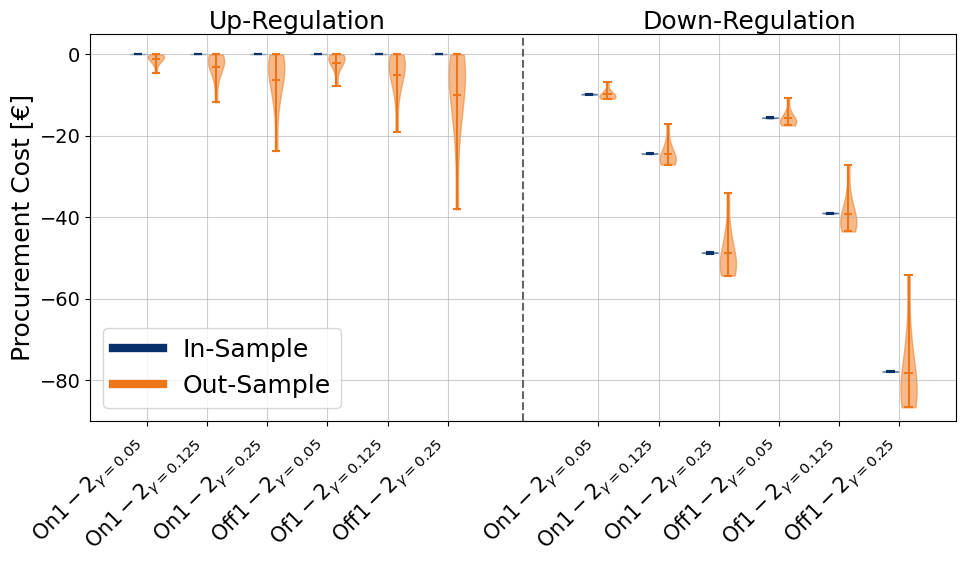

In [95]:
fig_asy_violins = pf.plot_penalty_violins_combined(
    up_in_c, up_out_c,
    down_in_c, down_out_c,
    Deviators_collapsed,
    ylim=(-90, 5)
)
fig_asy_violins.savefig("../Figures/Results/penalty_violins_asy.pdf")

In [96]:
# Bids contributing up / down for onshore 1 gamma = 0.125
print("bids contributing up bin", np.round(data_bin["bids"]["B_pol_up_out"][2, :], 3))
print("bids contributing up asymmetry", np.round(data_asy_GDCA["bids"]["B_pol_up_out"][2, :], 3))
print("bids contributing down bin", np.round(data_bin["bids"]["B_pol_down_out"][2, :], 3))
print("bids contributing down asymmetry", np.round(data_asy_GDCA["bids"]["B_pol_down_out"][2, :], 3))

bids contributing up bin [-0.001  0.    -0.013 -0.023 -0.004 -0.048 -0.096 -0.002 -0.009 -0.348]
bids contributing up asymmetry [-0.001  0.    -0.013 -0.023 -0.004 -0.048 -0.096 -0.002 -0.009 -0.348]
bids contributing down bin [2.65  2.671 2.311 2.305 2.485 2.034 1.929 2.565 2.441 1.141]
bids contributing down asymmetry [2.65  2.671 2.311 2.305 2.485 2.034 1.929 2.565 2.441 1.141]


In [97]:
np.round(data_asy_GDCA["aggregates"]["pol_out_avg"], 3) - np.round(data_bin["aggregates"]["pol_out_avg"], 3)

array([[  94.927,  -93.583,    2.328,   17.882],
       [  94.927,  -93.583,    2.328,   17.882],
       [   0.   ,    0.   ,    0.423,    3.25 ],
       [   0.   ,    0.   ,    0.423,    3.25 ],
       [-158.33 ,  156.078,   -2.743,  -21.196],
       [-158.33 ,  156.078,   -2.743,  -21.196],
       [ 146.796, -144.647,    3.683,   28.699],
       [ 146.795, -144.647,    3.683,   28.699],
       [   0.   ,    0.   ,    0.678,    5.202],
       [   0.   ,    0.   ,    0.678,    5.202],
       [-244.202,  240.747,   -4.368,  -33.836],
       [-244.203,  240.747,   -4.368,  -33.836]])

In [98]:
np.round(pBIN_dev - pBM_dev, 2)
# array([[  94.93,  -93.58,   20.21],
#        [  94.93,  -93.58,   20.21],
#        [   0.  ,   -0.  ,    3.67],
#        [  -0.  ,    0.  ,    3.67],
#        [-158.33,  156.08,  -23.94],
#        [-158.33,  156.08,  -23.94],
#        [ 146.8 , -144.65,   32.38],
#        [ 146.8 , -144.65,   32.38],
#        [  -0.  ,    0.  ,    5.88],
#        [   0.  ,   -0.  ,    5.88],
#        [-244.2 ,  240.75,  -38.2 ],
#        [-244.2 ,  240.75,  -38.2 ]])

array([[  94.93,  -93.58,   20.21],
       [  94.93,  -93.58,   20.21],
       [   0.  ,    0.  ,    3.67],
       [   0.  ,   -0.  ,    3.67],
       [-158.33,  156.08,  -23.94],
       [-158.33,  156.08,  -23.94],
       [ 146.8 , -144.65,   32.38],
       [ 146.8 , -144.65,   32.38],
       [  -0.  ,    0.  ,    5.88],
       [   0.  ,   -0.  ,    5.88],
       [-244.2 ,  240.75,  -38.2 ],
       [-244.2 ,  240.75,  -38.2 ]])

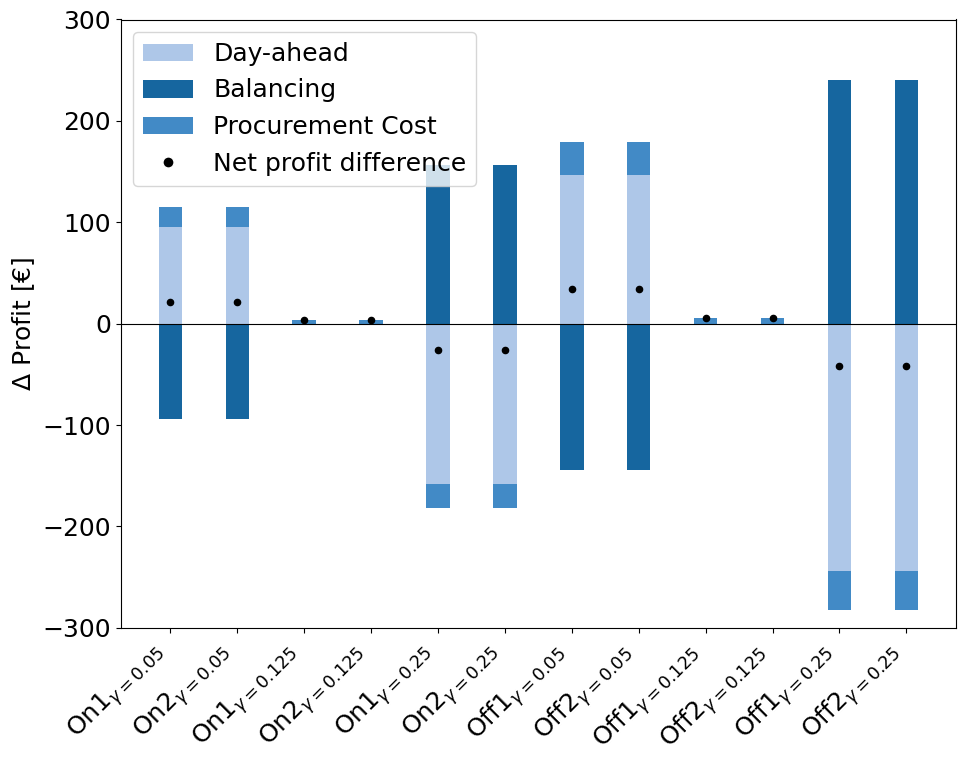

In [99]:
fig_prof_diff_asy = pf.stacked_posneg_diff_matrix(pBM_dev, pBIN_dev, Deviators, markets_d, participant_type="Polluters",
                               figsize=(10,8), labelsize=18, titlesize=18, fontsize=18, loc = "best")

fig_prof_diff_asy.savefig("../Figures/Results/fig_profits_asy.pdf")

Big Q

In [100]:
p_list_bigQ = data_bigQ["GDCA"].aggregates.pol_out_avg
bigQ = q_up + q_down

In [101]:
p_list_bigQ = [
    data_bin["aggregates"]["pol_out_avg"], 
    data_bigQ["aggregates"]["pol_out_avg"]
]
Q_up_list = [q_up + q_down, q_up + q_down]
Q_down_list = [q_down + q_up, q_down + q_up]

KeyError: 'aggregates'

In [ ]:
data_bigQ["GDCA"].aggregates.mean_pol_DA_bids_out 

12×1 Matrix{Float64}:
 33.18400000001144
 33.183999999999195
 33.1839999999974
 33.184
 33.18399999999783
 33.184000000000076
 53.094000000000584
 53.09400000000534
 53.093999999999845
 53.0939999999738
 53.09399999999698
 53.09399999999938

In [ ]:
data_bigQ["GDCA"].aggregates.mean_flex_DA_bids_out 

8×1 Matrix{Float64}:
   0.0
   0.0
   0.0
   0.0
  82.33200000001821
 450.0
 450.0
 450.0

In [ ]:
p_list_bigQ

12×4 Matrix{Float64}:
 2356.06  156.114   -6.61873  -60.0337
 2356.06  156.114   -6.61873  -60.0337
 2356.06  156.114   -6.61873  -60.0337
 2356.06  156.114   -6.61873  -60.0337
 2356.06  156.114   -6.61873  -60.0337
 2356.06  156.114   -6.61873  -60.0337
 3636.94  241.001  -10.5946   -96.0863
 3636.94  241.001  -10.5946   -96.0863
 3636.94  241.001  -10.5946   -96.0863
 3636.94  241.001  -10.5946   -96.0863
 3636.94  241.001  -10.5946   -96.0863
 3636.94  241.001  -10.5946   -96.0863

In [ ]:
sum(p_list_bigQ[:, 2])*100/1040

-9.930765369589146

In [ ]:
sum(p_list_bigQ[:, 3])/1040*100

-90.06923463041083

In [ ]:
sum(p_list_bigQ[:, 3]) + sum(p_list_bigQ[:, 2])

-1039.9999999999998

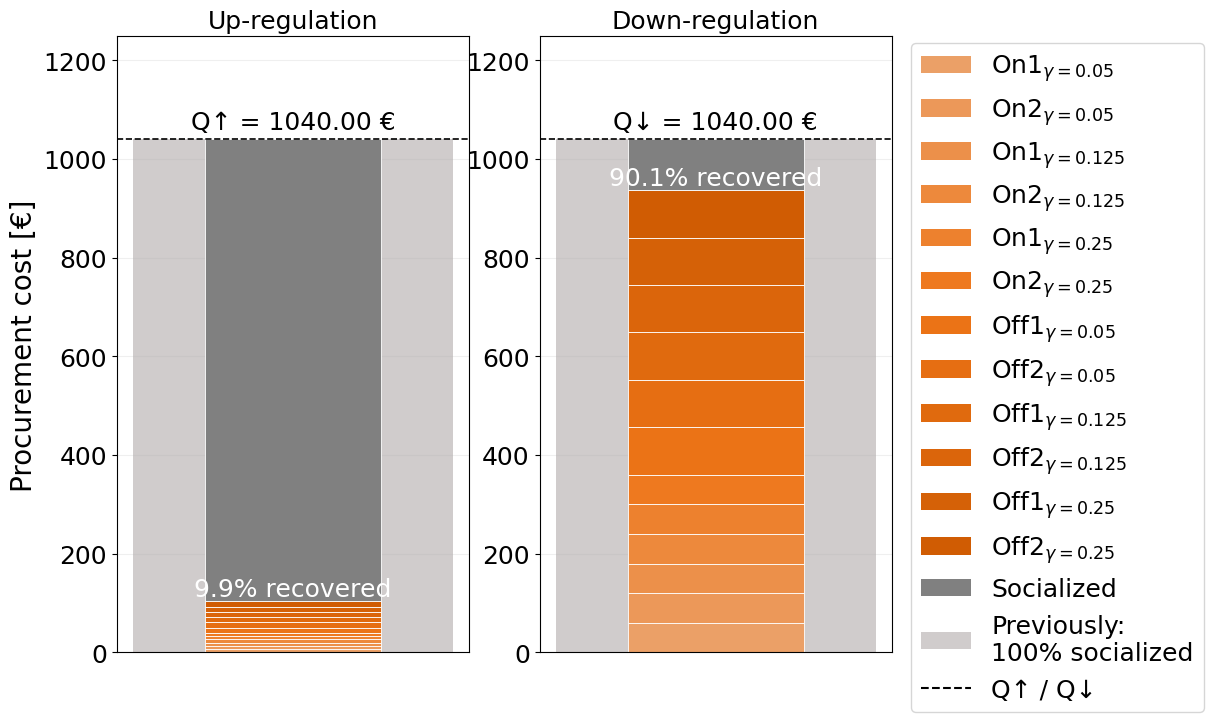

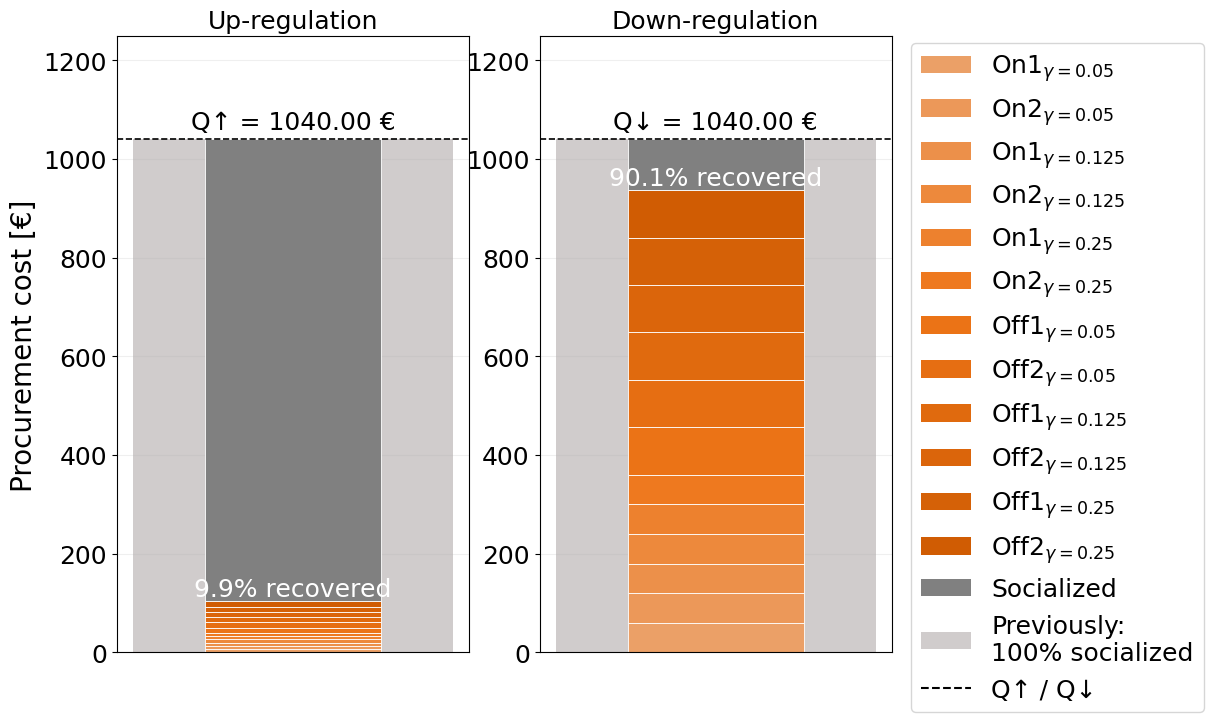

In [102]:
pf.plot_socialized_vs_individualized_FCB_only(
    pBIN_fcb=p_list_bigQ,      # assuming index 1 is FCB
    Q_up=bigQ,
    Q_down=bigQ,
    tech_colors=tech_colors,
    polluters=Deviators, 
    figsize=(10, 8),
    prev_social_color="#d0cccc",
    asy = False
)

### Difference in Q 

In [103]:
Q_up_list = [data_Cf_fold9['q_up'][i] for i in range(5)]
Q_down_list = [data_Cf_fold9['q_down'][i] for i in range(5)]

In [104]:
Q_up_list, Q_down_list

([400.0, 480.0, 560.0, 640.0, 880.0], [160.0, 320.0, 480.0, 640.0, 1120.0])

In [105]:
run_indices = [1, 2, 4, 5, 6] # Skipping 3 as it is FCB_run
for i, idx in enumerate(run_indices):
    print(idx)
    print(Q_up_list[i])
    print(R_Cf_GDCA[idx]["history"]["history_insample"][0]["ppDA"])
    print(R_Cf_GDCA[idx]["history"]["history_insample"][1]["ppDA"])

1
400.0
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
2
480.0
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
4
560.0
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
[34.51 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
5
640.0
[90.79 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
[90.79 34.51 34.51 34.51 34.51 34.51 55.22 55.22 55.22 55.22 55.22 55.22]
6
880.0
[84.47 34.84 34.51 34.84 34.51 34.84 58.37 55.22 55.74 55.22 55.22 56.88]
[100.    34.51  19.31  34.84  34.51  34.84  58.37  55.22  55.74  55.22
  55.22  56.88]


In [106]:
run_indices = [1, 2, 4, 5, 6] # Skipping 3 as it is FCB_run
for i, idx in enumerate(run_indices):
    print(idx)
    print(Q_up_list[i])
    print(R_Cf_GDCA[idx]["history"]["history_insample"][0]["penalty_cost"])
    print(R_Cf_GDCA[idx]["history"]["history_insample"][1]["penalty_cost"])

1
400.0
143.6609485368315
143.6609485368316
2
480.0
287.321897073663
287.3218970736627
4
560.0
574.6437941473255
574.6437941473257
5
640.0
794.3975782038343
794.3975782038344
6
880.0
866.6155398587284
866.6155398587284


In [107]:
def costs_per_fold(fold, nS, nP, nF, nR, prob_all, DA_bids, B_bids_pol, B_pol_expected, 
                   B_bids_flex, R_bids, Cf_Rup, Cf_Rdown, Q_up=None, Q_down=None, tol=1e-6):
    # This is for 1 fold
    # B_bids corresponds to the up [0] and down [0] bids that are contributing to the system imbalance
    pol_cost = [None] * nP
    flex_cost = [None] * nF
    reg_cost = [None] * nR

    include_penalty = Q_up is not None and Q_down is not None
    prob = prob_all
    
    k_up = np.zeros((nS, nP))
    k_down = np.zeros((nS, nP))

    # --- imbalance shares ---
    for w in range(nS):
        print(B_bids_pol[0])
        total_imbalance = np.sum(B_bids_pol[0][w, :]) + np.sum(B_bids_pol[1][w, :]) # SUM OF UP AND DOWN REGULATION DEVIATIONS FOR THIS SCENARIO
        z_down = np.sum(B_bids_pol[1][w, :]) # DOWN REGULATION
        z_up = np.sum(B_bids_pol[0][w, :])  # UP REGULATION

        for p in range(nP):
            bid_up = B_bids_pol[0][w, p]
            bid_down = B_bids_pol[1][w, p]

            if total_imbalance > tol and bid_down > 0:
                k_down[w, p] = bid_down / z_down
            elif total_imbalance < -tol and bid_up < 0:
                k_up[w, p] = bid_up / z_up

    # --- polluters ---
    for p in range(nP):
        cost_DA = DA_bids[0][p] * Cp[p]
        cost_B = Cp[p]*B_pol_expected[p]
        penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
        penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0

        pol_cost[p] = [cost_DA, cost_B, penalty_up, penalty_down]


    # --- flexible units ---
    for f in range(nF):
        cost_DA = DA_bids[1][f] * Cf[f]
        cost_B = Cf[f] * (B_bids_flex[0][f] - B_bids_flex[1][f])               # IT SHOULD BE FIRST UP [0] THEN  DOWN [0] BUT THE VALUES ARE SWAPPED FOR NOW
        cost_R = (
            R_bids[0][f] * Cf_Rup[f]
            + R_bids[1][f] * Cf_Rdown[f])
        cost_R = 0
        flex_cost[f] = [cost_DA, cost_B, cost_R]

    # --- regular generators ---
    for r in range(nR):
        cost_DA = DA_bids[2][r] * Cr[r]
        reg_cost[r] = [cost_DA]


    return pol_cost, flex_cost, reg_cost

In [108]:
data_CF7 = R_Cf_GDCA[6]
data_CF1 = R_Cf_GDCA[1]
Q1_up = Q_up_list[0]
Q7_up = Q_up_list[-1]

Q1_down = Q_down_list[0]
Q7_down = Q_down_list[-1]

systems_costs_1_in = []
systems_costs_1_out = []
systems_costs_7_in =[]
systems_costs_7_out =[]

prob_insample = data_CF1["split_info"]["in_sample_prob"]
prob_outsample = data_CF1["split_info"]["out_sample_prob"]


for fold in range (1):
    flex_bids_insample = [data_CF1["bids"]["B_flex_up_in"], data_CF1["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_CF1["bids"]["DA_bids_insample"], data_CF1["bids"]["B_bids_all_insample"], data_CF1["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=Q1_up, Q_down=Q1_down, tol=1e-6)
    systems_costs_1_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_CF1["bids"]["B_flex_up_out"], data_CF1["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_CF1["bids"]["DA_bids_outsample"], data_CF1["bids"]["B_bids_all_outsample"], data_CF1["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=Q1_up, Q_down=Q1_down, tol=1e-6)
    systems_costs_1_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_insample = [data_CF7["bids"]["B_flex_up_in"], data_CF7["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_CF7["bids"]["DA_bids_insample"], data_CF7["bids"]["B_bids_all_insample"], data_CF7["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=Q7_up, Q_down=Q7_down, tol=1e-6)
    systems_costs_7_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_CF7["bids"]["B_flex_up_out"], data_CF7["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_CF7["bids"]["DA_bids_outsample"], data_CF7["bids"]["B_bids_all_outsample"], data_CF7["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=Q7_up, Q_down=Q7_down, tol=1e-6)
    systems_costs_7_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 

C:\Users\Gloria\AppData\Local\Temp\ipykernel_720\1265926137.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
C:\Users\Gloria\AppData\Local\Temp\ipykernel_720\1265926137.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0


In [109]:
def split_costs(system_costs):
    pol  = [np.sum(c["pol"])  for c in system_costs]
    flex = [np.sum(c["flex"]) for c in system_costs]
    reg  = [np.sum(c["reg"])  for c in system_costs]
    tot = [np.sum(c["reg"]) + np.sum(c["flex"]) + np.sum(c["pol"]) for c in system_costs]
    procurement_cost_up = [np.sum([c['pol'][p][2] for p in range(nP)]) for c in system_costs]
    procurement_cost_down = [np.sum([c['pol'][p][3] for p in range(nP)]) for c in system_costs]

    return np.array(pol), np.array(flex), np.array(reg), np.array(tot), np.array(procurement_cost_up), np.array(procurement_cost_down)

def systems_costs(system_costs_BM_in, system_costs_BM_out, system_costs_FCB_in, system_costs_FCB_out, figsize = (10, 8), fontsize = 18):
    BM_in  = split_costs(system_costs_BM_in)
    BM_out = split_costs(system_costs_BM_out)
    FCB_in  = split_costs(system_costs_FCB_in)
    FCB_out = split_costs(system_costs_FCB_out)

    components = ["Deviators", "Flexible", "Base Loads", "Total"]
    n_folds = len(BM_in[0])  # assuming BM_in[i] is length n_folds

    x = np.arange(len(components))

    plt.figure(figsize=figsize)

    for i, comp in enumerate(components):
        # In-sample
        y_in = np.array(FCB_in[i]) - np.array(BM_in[i])
        plt.scatter(np.full(n_folds, x[i]-0.1), 
                    y_in, color='#08306b', alpha=0.6, label='In-sample' if i==0 else "")
        # Out-of-sample
        y_out = np.array(FCB_out[i]) - np.array(BM_out[i])
        plt.scatter(np.full(n_folds, x[i]+0.1), 
                    y_out, color='#EE7518', alpha=0.6, label='Out-of-sample' if i==0 else "")

    np.mean(np.array(FCB_in[0]) - np.array(BM_in[0]))
    np.mean(np.array(FCB_in[0]) - np.array(BM_in[0]))
    
    # Optional: mean markers
    for i in range(4):
        plt.plot(x[i]-0.1, np.mean(np.array(FCB_in[i]) - np.array(BM_in[i])), 'o', color='#08306b', markersize=10)
        plt.plot(x[i]+0.1, np.mean(np.array(FCB_out[i]) - np.array(BM_out[i])), 'o', color='#EE7518', markersize=10)
    
    print("total diff : ", np.mean(np.array(FCB_out[0]) - np.array(BM_out[0])))
    print("total diff flexibles : ", np.mean(np.array(FCB_out[1]) - np.array(BM_out[1])))

    dif_procurement_cost_up_in =np.mean(np.array(FCB_in[4]) - np.array(BM_in[4]))
    dif_procurement_cost_up_out =np.mean(np.array(FCB_out[4]) - np.array(BM_out[4]))
    dif_procurement_cost_down_in =np.mean(np.array(FCB_in[5]) - np.array(BM_in[5]))
    dif_procurement_cost_down_out =np.mean(np.array(FCB_out[5]) - np.array(BM_out[5]))
    
    print("penalties:", dif_procurement_cost_down_out + dif_procurement_cost_up_out)

    plt.annotate(
    '',  # no text, just arrow
    xy=(0-0.1, dif_procurement_cost_down_in),  # arrow tip (right end)
    xytext=(0-0.1, 0),    # arrow start (left end)
    arrowprops=dict(color='gray', arrowstyle='-|>', lw=1)
    )
    
    # Add text label
    plt.text(
        0,  # roughly center
        dif_procurement_cost_down_in/2,  # slightly below the arrow
        f"Due to: procurement \ncost for down-regulation",
        ha='left', va='center', fontsize=fontsize-2, color = 'gray'
    )

    if dif_procurement_cost_up_in > 0:
        plt.annotate(
            '',  # no text, just arrow
            xy=(0-0.1, dif_procurement_cost_down_in + dif_procurement_cost_up_in),  # arrow tip (right end)
            xytext=(0-0.1, dif_procurement_cost_down_in),    # arrow start (left end)
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2)
        )
        plt.annotate(
            '',  # no text, just arrow
            xy=(0+0.1, dif_procurement_cost_down_out),  # arrow tip (right end)
            xytext=(0+0.1, 0),    # arrow start (left end)
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2)
        )

    plt.annotate(
        '',  # no text, just arrow
        xy=(0 + 0.1, dif_procurement_cost_down_out + dif_procurement_cost_up_out),  # arrow tip (right end)
        xytext=(0 + 0.1, dif_procurement_cost_down_out),    # arrow start (left end)
        arrowprops=dict(color='gray', arrowstyle='-|>', lw=1)
    )

    # Add text label
    plt.text(
        0.2,  # roughly center
        dif_procurement_cost_down_out + dif_procurement_cost_up_out/2,  # slightly below the arrow
        f"Due to: procurement \ncost for up-regulation",
        ha='left', va='center', fontsize=fontsize-2, color = 'gray'
    )

    plt.xticks(x, components, rotation = 45)
    plt.ylabel(rf"$\Delta$ Costs (FCB − BM) [€]", fontsize = fontsize)
    plt.axhline(0, color='black', linestyle='--', lw=1)
    plt.legend(fontsize = fontsize, loc='center right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    return fig

In [110]:
#deviations for rhe runs
# Slicing with [:-1] excludes the last sorted key


# Dictionary for results
expected_bids_results = {}

# run_idx from 1 to 7
run_indices = [1, 2, 4, 5, 6] # Skipping 3 as it is FCB_run

for idx in run_indices:
    # 1. Access data: axis 0=up/down, 1=scenarios, 2=generators
    raw_bids = R_Cf_GDCA[idx]["bids"]["B_bids_all_outsample"]
    all_bids = np.asarray(raw_bids) 
    
    # 2. Access probabilities (90 elements)
    probs_obj = np.asarray(R_Cf_GDCA[idx]["split_info"]["out_sample_prob"])
    probs = np.array(probs_obj[0], dtype=float)

    # 3. Reshape probs for broadcasting: (1, 90, 1)
    # This aligns with (2, 90, n_gen)
    probs_reshaped = probs.reshape(1, -1, 1)
    
    # 4. Multiply bids by probabilities and sum along scenarios (axis 1)
    # Resulting shape: (2, n_gen)
    mean_bids = np.sum(all_bids * probs_reshaped, axis=1)
    
    
    # 5. Store results
    expected_bids_results[idx] = {
        "up": mean_bids[0, :],
        "down": mean_bids[1, :],
        "average": (mean_bids[0, :] + mean_bids[1, :])
    }

dev_Q_list = [
    np.asarray(R_Cf_GDCA[r]["bids"]["B_pol_out"]).ravel()
    for r in sorted(R_Cf_GDCA.keys())[:-1]
]


print("Calculated expected bids for the new 3-axis structure.")
print(np.round(expected_bids_results[5]["up"], 1))  # Example: print expected up bids for run_idx 1
print(np.round(expected_bids_results[5]["down"], 1))  # Example: print expected down bids for run_idx 1
print(np.round(R_Cf_GDCA[5]["bids"]["B_pol_out"], 1))
print(np.round(R_Cf_GDCA[5]["bids"]["B_pol_up_out"], 1))
display(np.round(R_Cf_GDCA[5]["bids"]["B_bids_all_outsample"], 1))


Calculated expected bids for the new 3-axis structure.
[-55.7  -0.3  -0.3  -0.3  -0.3  -0.3  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-55.5]
 [  0.8]
 [  0.8]
 [  0.8]
 [  0.8]
 [  0.8]
 [  1.3]
 [  1.3]
 [  1.3]
 [  1.3]
 [  1.3]
 [  1.3]]
[[-55.5]
 [ -0.3]
 [ -0.3]
 [ -0.3]
 [ -0.3]
 [ -0.3]
 [ -0.6]
 [ -0.6]
 [ -0.6]
 [ -0.6]
 [ -0.6]
 [ -0.6]]


array([[[-55.8,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [-58. ,  -1.8,  -1.8, ...,  -2.8,  -2.8,  -2.8],
        [-55.3,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [-57.6,  -1.3,  -1.3, ...,  -2.1,  -2.1,  -2.1],
        [-55.6,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [-57.7,  -1.4,  -1.4, ...,  -2.3,  -2.3,  -2.3]],

       [[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]]],
      shape=(2, 90, 12))

Plotting deviations for model: 400.0
[0.79292888 0.79292888 0.79292888 0.79292888 0.79292888 0.79292888
 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519]
Plotting deviations for model: 480.0
[0.79292888 0.79292888 0.79292888 0.79292888 0.79292888 0.79292888
 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519]
Plotting deviations for model: 560.0
[0.79292888 0.79292888 0.79292888 0.79292888 0.79292888 0.79292888
 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519]
Plotting deviations for model: 640.0
[0.79292888 0.79292888 0.79292888 0.79292888 0.79292888 0.79292888
 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519 1.26475519]
Plotting deviations for model: 880.0
[-55.48707112   0.79292888   0.79292888   0.79292888   0.79292888
   0.79292888   1.26475519   1.26475519   1.26475519   1.26475519
   1.26475519   1.26475519]


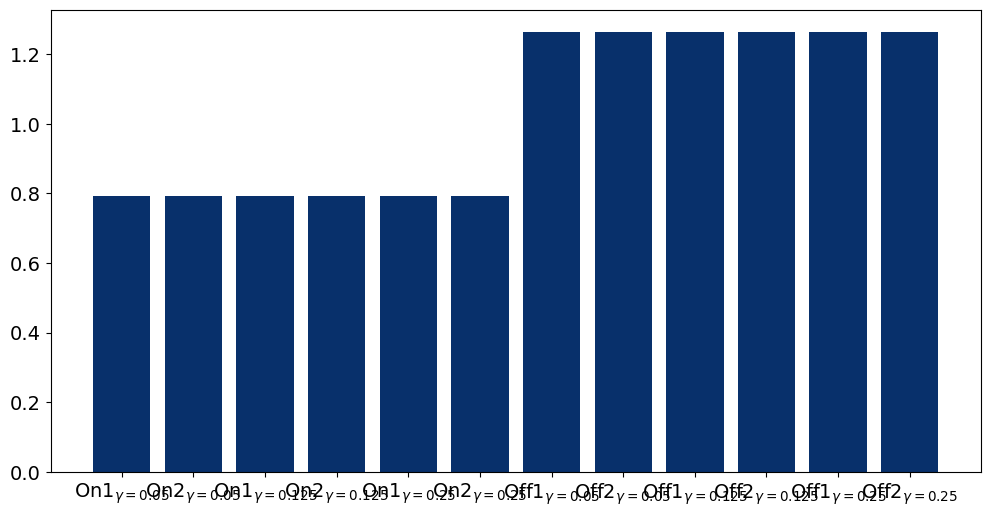

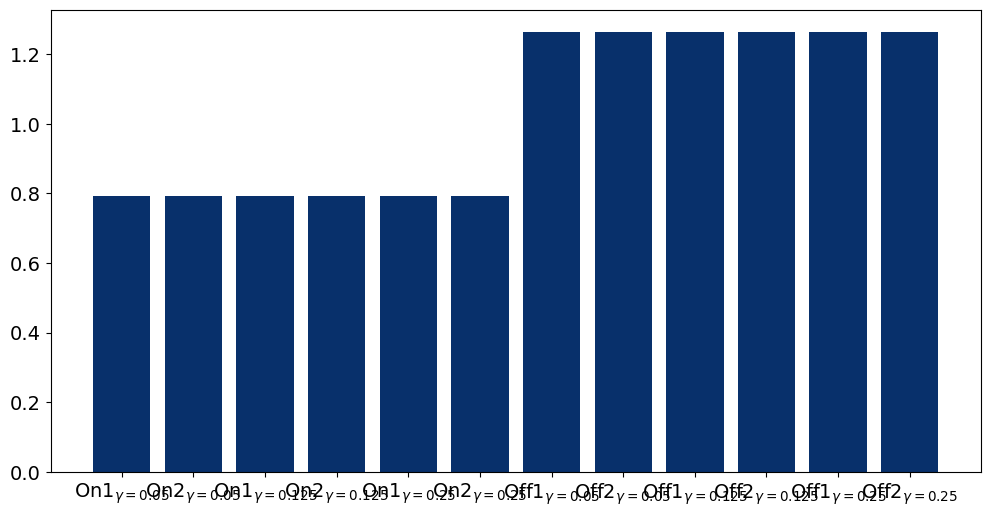

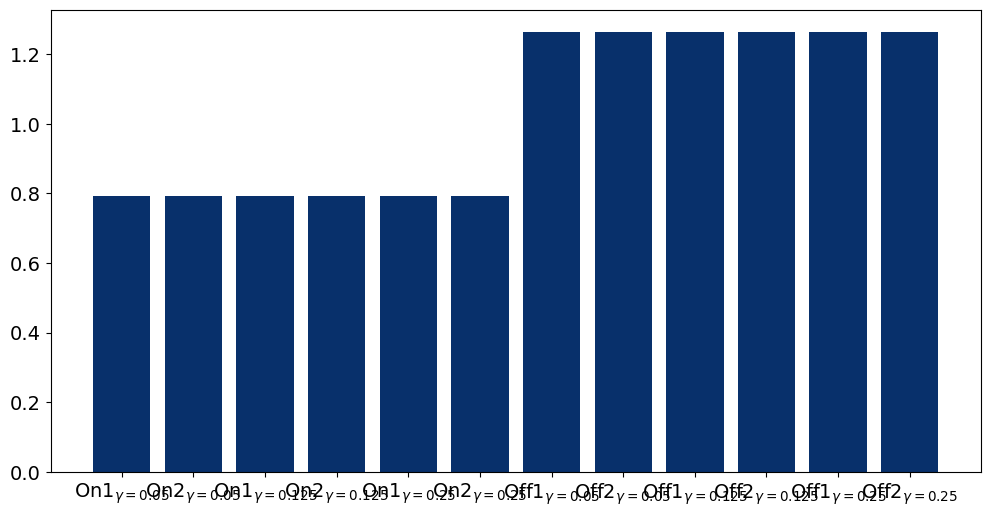

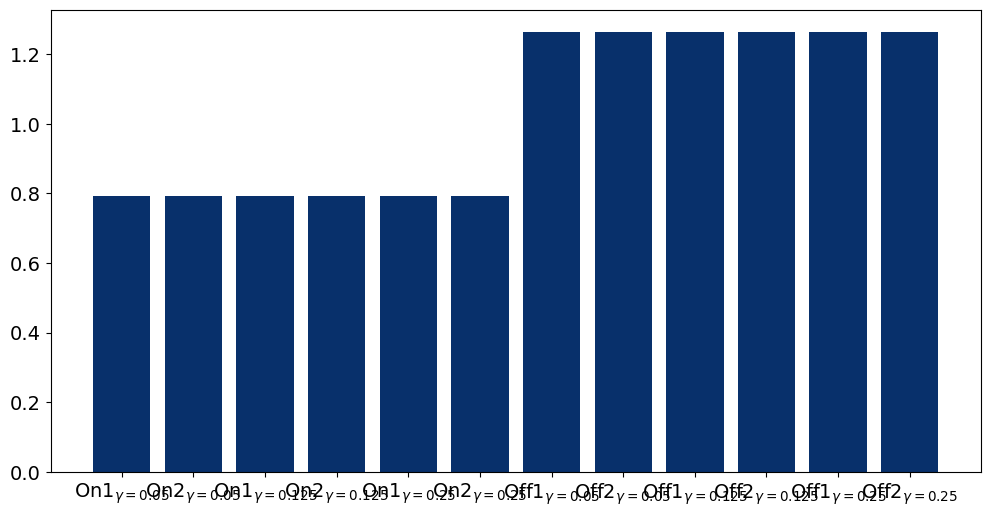

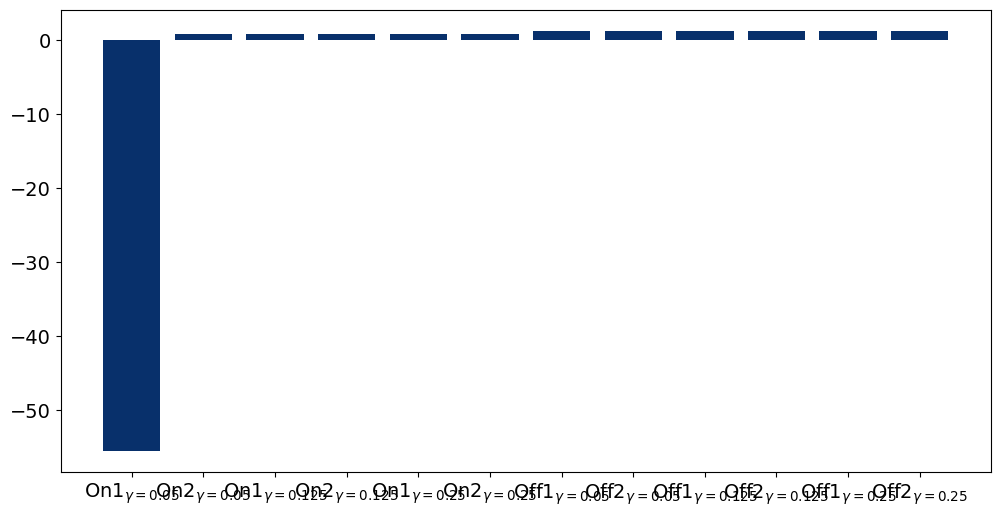

In [111]:
### plot power deviations for dev_Cf[7]
for i in range(len(dev_Q_list)):
    print(f"Plotting deviations for model: {Q_up_list[i]}")
    print(dev_Q_list[i])
    plt.figure(figsize=(12, 6))
    plt.bar(
        Deviators,
        dev_Q_list[i],  # Index 6 corresponds to Cf_12 (7th in the list)
        color=bar_color
    )

In [112]:
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

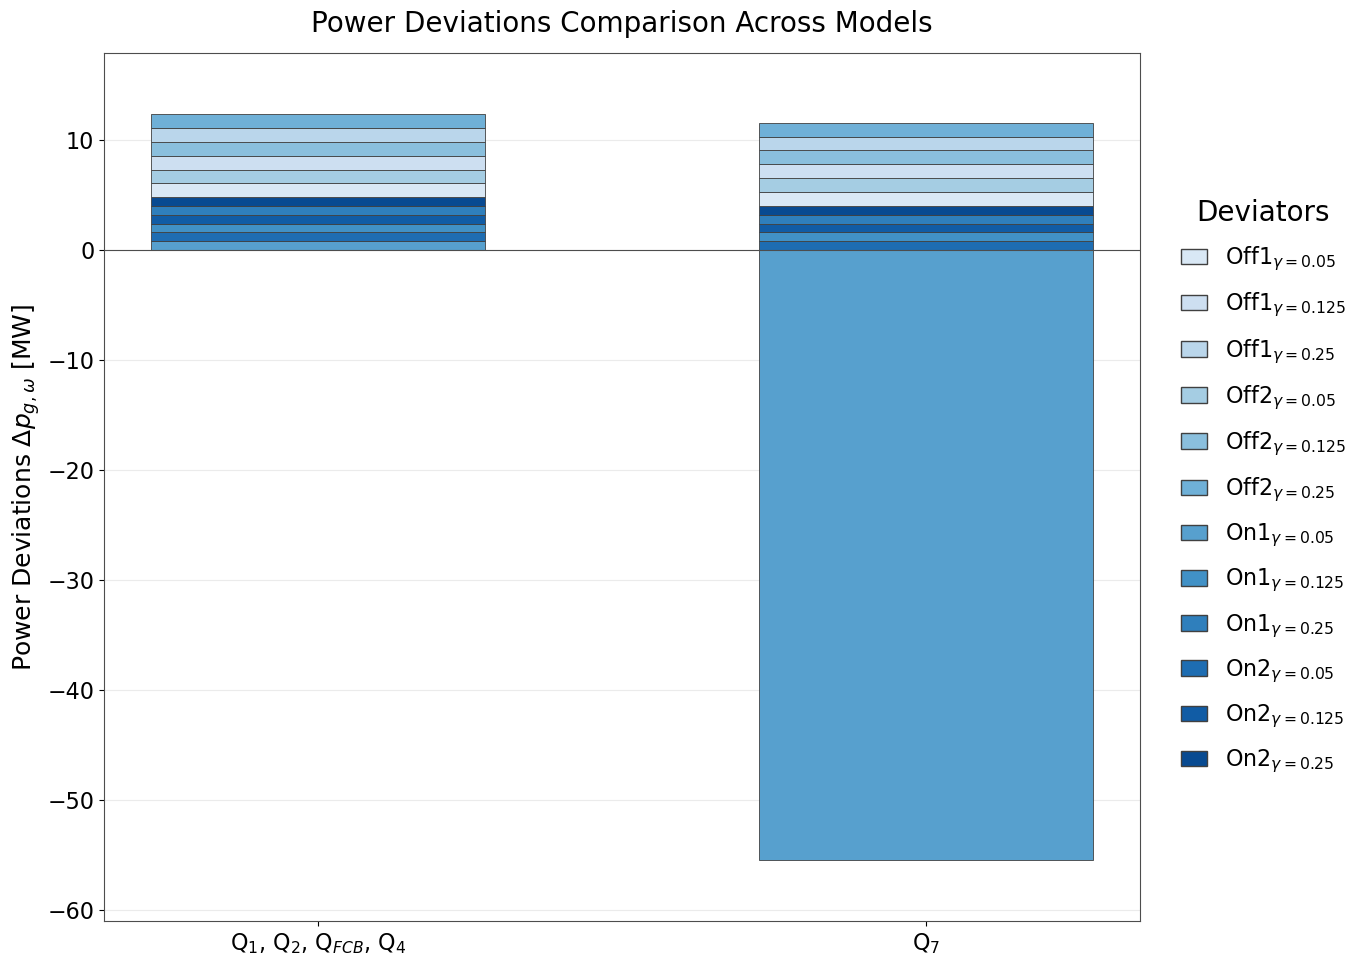

In [113]:

B_bids = pf.plot_power_deviations_grouped(
    model_names=model_names_Cf,
    deviations_list=dev_Q_list,
    polluters=Deviators,
    base_color="Blues",      # Możesz zmienić na "Reds", "Greens" itd.
    figsize=(14, 10),         # Rozmiar zgodny z Twoimi preferencjami
    legend_title="Deviators", # Tytuł legendy
    title_fontsize=20,
    label_fontsize=18,
    tick_fontsize=16,
    legend_fontsize=16,
    legend_title_fontsize=20,
)
#B_bids.savefig("Plots/B_bids_Cf_models_comparison.pdf", bbox_inches='tight')

In [114]:
Tech_colors = {
    "On":   "#C85700", # Soft Orange
    "Off": "#EE6318", # Teal
    "SCGT":     "#3f8fc4", # Deep Night Teal (From your preferred set)
    "CCGT":     "#08306b",  # Blue-teal
    "Extra_blue": "#2257a5", # Dark Blue
    "Biomass":  "#4CCA53",  # Green
    "Coal":     "#2E6F40",  # Dark green
    "Waste":    "#388E3C", # Forest Green (The "Waste" green you need)
}


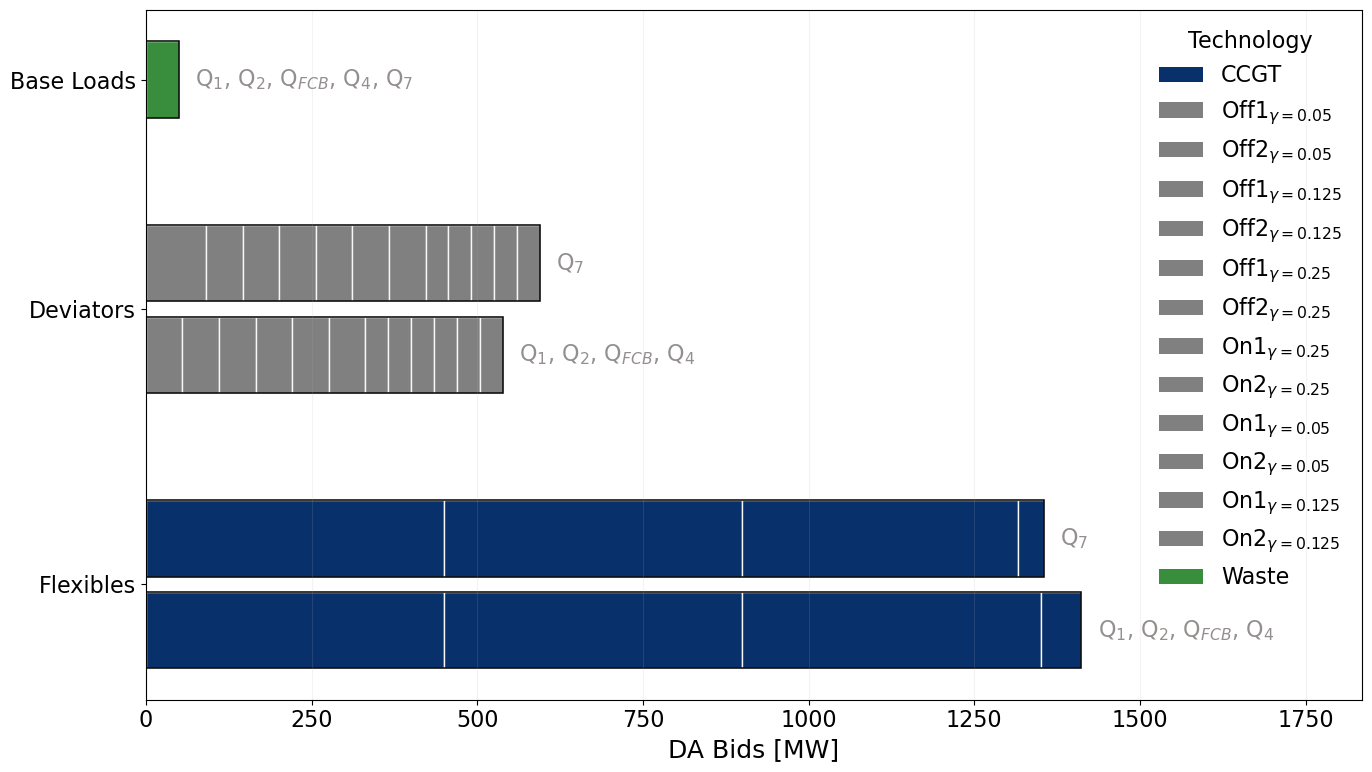

In [115]:
DA_comparison = pf.plot_DA_bids_grouped_identical(
    DA_bids_Q,
    types_to_plot=["Deviators", "Flexibles", "Base loads"],
    names_by_type=names_by_type,
    tech_colors=Tech_colors,
    sep_lw = 1.0,
    bar_height=0.5,
    sep_color = "#f7f7f7",
       # very light gray instead of white
    title_fontsize=20,
    label_fontsize=18,
    tick_fontsize=16,
    legend_fontsize=16,
    legend_title_fontsize=18,
    figsize=(14,8)
)

#DA_comparison.savefig("Plots/DA_bids_Cf_models_comparison.pdf", bbox_inches='tight')

            

profits

In [116]:
profit_dev_ind = {}
profit_dev_bin = {}
profit_dev_LP = {}
profit_flex_bin = {}
profit_flex_ind = {}
profit_flex_LP = {}
profit_reg_ind = {}
profit_reg_bin = {}
profit_reg_LP = {}
profit_dev_BM = {}
profit_flex_BM = {}
profit_reg_BM = {}


for i in range(1, 7):
    # --- POLLUTERS ---
    dev_ind = []
    dev_bin = []
    dev_LP = []
    flex_ind = []
    flex_bin = []
    flex_LP = []
    reg_ind = []
    reg_bin = []
    reg_LP = []
    reg_BM = []
    dev_BM =[]
    flex_BM = []
    
    for j in range(12):
        row_ind = R_Cf_GDCA[i]["profits"]["pol_out_ind"][j][0]
        row_bin = R_Cf_GDCA[i]["profits"]["pol_out_bin"][j][0]
        row_LP = R_Cf_GDCA[i]["profits"]["pol_out"][j][0]
        row_LP_BM = R_Cf_BM[i]["profits"]["pol_out"][j][0]
        # Logika: [Base, DA, Penalty_sum (3+4)]
        dev_ind.append([row_ind[0], row_ind[1], row_ind[2], row_ind[3]])
        dev_bin.append([row_bin[0], row_bin[1], row_bin[2], row_bin[3]])
        dev_LP.append([row_LP[0], row_LP[1], row_LP[2], row_LP[3]])
        dev_BM.append([row_LP_BM[0], row_LP_BM[1], row_LP_BM[2], row_LP_BM[3]])
        
    profit_dev_ind[i] = np.array(dev_ind)
    profit_dev_bin[i] = np.array(dev_bin)
    profit_dev_LP[i] = np.array(dev_LP)
    profit_dev_BM[i] = np.array(dev_BM)
    # --- FLEXIBLES ---
    for j in range(8):
        row_ind = R_Cf_GDCA[i]["profits"]["flex_out_ind"][j][0]
        row_bin = R_Cf_GDCA[i]["profits"]["flex_out_bin"][j][0]
        row_LP = R_Cf_GDCA[i]["profits"]["flex_out"][j][0]
        row_LP_BM = R_Cf_BM[i]["profits"]["flex_out"][j][0]
        # Logika: [Base, DA, Penalty_sum (3+4)]
        flex_ind.append([row_ind[0], row_ind[1], row_ind[2] ])
        flex_bin.append([row_bin[0], row_bin[1], row_bin[2]])
        flex_LP.append([row_LP[0], row_LP[1], row_LP[2] ])
        flex_BM.append([row_LP_BM[0], row_LP_BM[1], row_LP_BM[2]])
    profit_flex_ind[i] = np.array(flex_ind)
    profit_flex_bin[i] = np.array(flex_bin)
    profit_flex_LP[i] = np.array(flex_LP)   
    profit_flex_BM[i] = np.array(flex_BM)

    for j in range(3):
        row_ind = R_Cf_GDCA[i]["profits"]["reg_out_ind"][j][0]
        row_bin = R_Cf_GDCA[i]["profits"]["reg_out_bin"][j][0]
        row_LP = R_Cf_GDCA[i]["profits"]["reg_out"][j][0]
        row_LP_BM = R_Cf_BM[i]["profits"]["reg_out"][j][0]
        reg_ind.append([row_ind[0]])
        reg_bin.append([row_bin[0]])
        reg_LP.append([row_LP[0]])
        reg_BM.append([row_LP_BM[0]])
    profit_reg_ind[i] = np.array(reg_ind)
    profit_reg_bin[i] = np.array(reg_bin)
    profit_reg_LP[i] = np.array(reg_LP)
    profit_reg_BM[i] = np.array(reg_BM)


In [117]:
R_Cf_GDCA[6]["profits"]["pol_out"][j][0]

4-element Vector{Float64}:
 1371.0099999999998
 1135.4979505822025
   -0.0
   -0.0

In [118]:
R_Cf_GDCA[6]["bids"]["B_pol_down_out"]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [119]:
R_Cf_GDCA[6]["bids"]["B_pol_down_out"]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [120]:
R_Cf_BM[6]["bids"]["B_pol_out"]

array([[ 0.79292888],
       [35.30292888],
       [ 0.79292888],
       [ 0.79292888],
       [ 0.79292888],
       [ 0.79292888],
       [ 1.26475519],
       [56.48475519],
       [ 1.26475519],
       [ 1.26475519],
       [ 1.26475519],
       [15.25475519]])

In [121]:
sum(DA_bids_Q['Q$_7$']['Deviators'])-sum(DA_bids_Q['Q$_1$']['Deviators'])

array([56.28])

In [122]:
sum(DA_bids_Q['Q$_1$']['Deviators'])

array([538.38])

In [123]:
sum(DA_bids_Q['Q$_7$']['Flexibles'])-sum(DA_bids_Q['Q$_1$']['Flexibles'])

array([-56.28])

In [124]:
profit_dev_bin

{1: array([[2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942]]),
 2: array([[2450.21      ,   56.29795058,  -11.49258174,  -12.85352066],
        [2450.21      ,   56.29795058,  -11.49258174,  -12.85352066],
        [245

In [125]:
profit_dev_bin

{1: array([[2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [2450.21      ,   56.29795058,   -9.57715145,   -6.42676033],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942],
        [3782.57      ,   86.63573028,  -15.40629085,  -10.24652942]]),
 2: array([[2450.21      ,   56.29795058,  -11.49258174,  -12.85352066],
        [2450.21      ,   56.29795058,  -11.49258174,  -12.85352066],
        [245

In [126]:
pBIN_pen_pol = {i: np.column_stack([profit_dev_bin[i][:, 2] , profit_dev_bin[i][:, 3]] ) for i in range(1,7)}


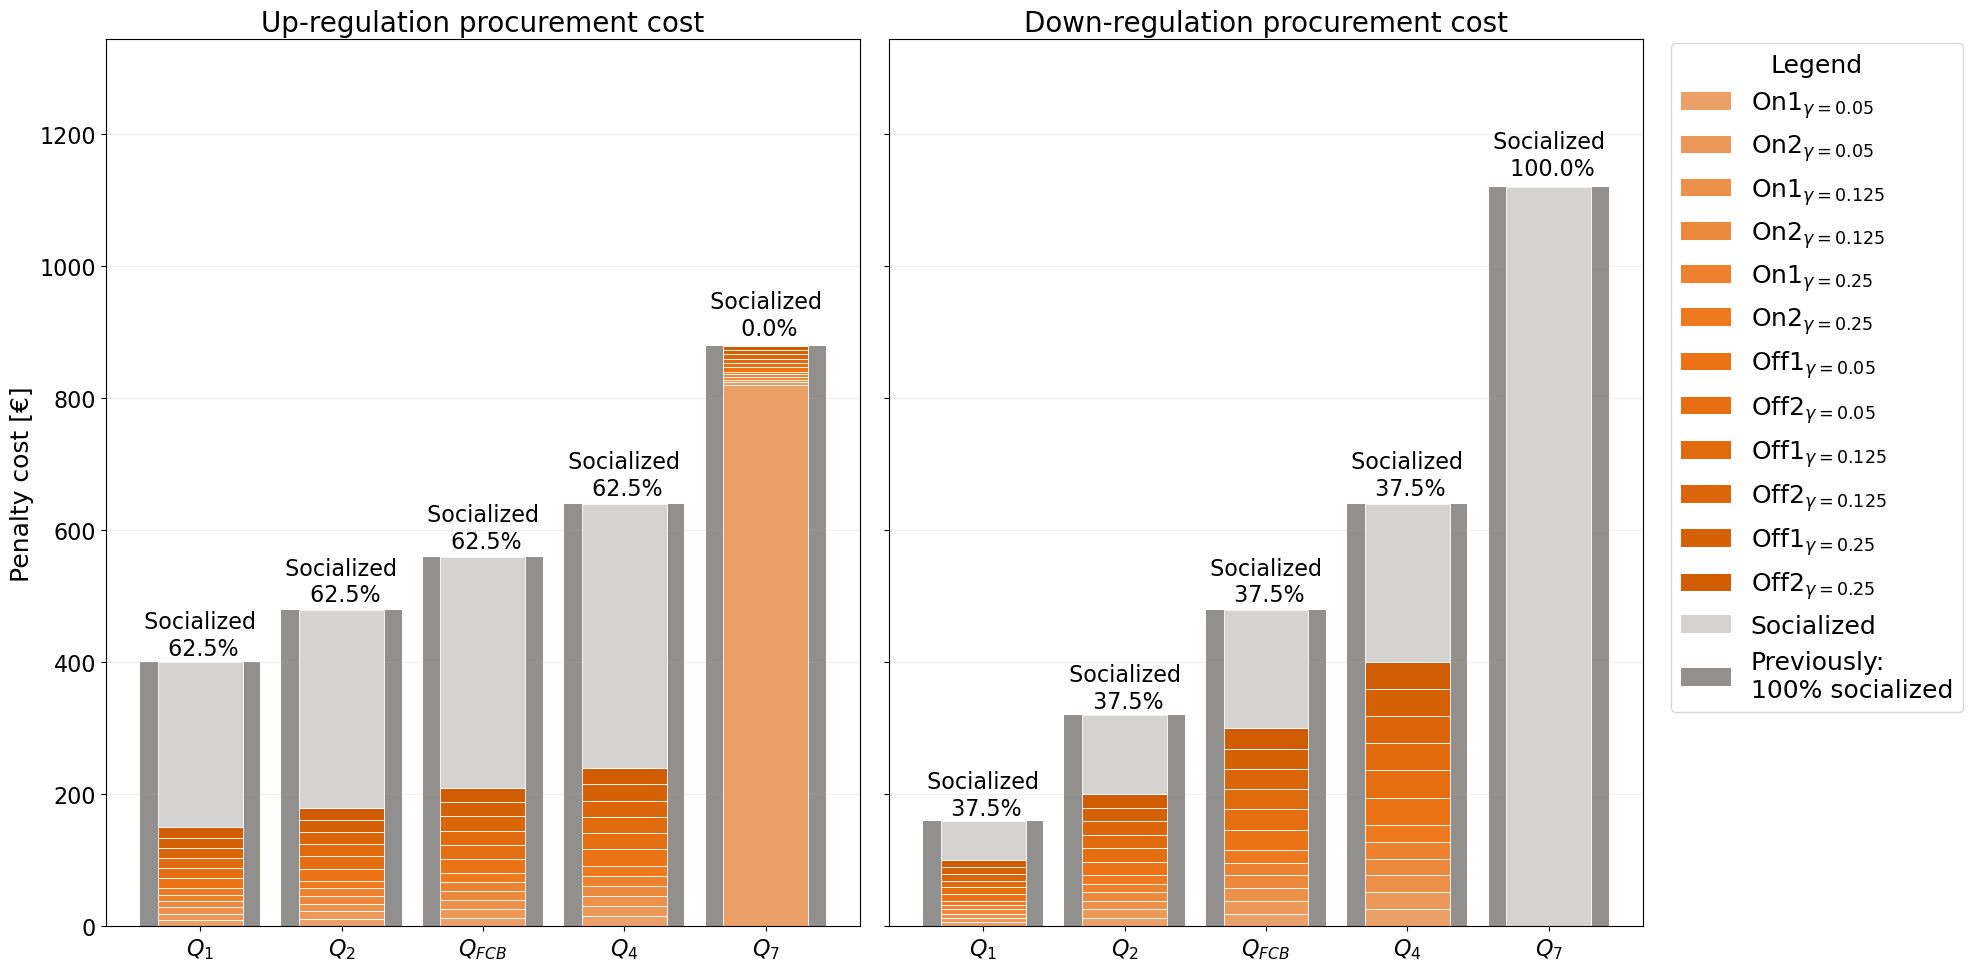

In [127]:
social_cost = pf.plot_socialized_vs_individualized_all_models_no_lines(
    pBIN_pen_by_model=pBIN_pen_pol,
    Q_up_by_model=Q_up_list,
    Q_down_by_model=Q_down_list,
    polluters=Deviators,
    model_order=[1,2,3,4,5],   # 3 will show as "FCB"
    figsize=(20, 10),
    anchors=("#EBA067", "#EE7518", "#D05C03"),
    show_prev_all_socialized=True, 
    social_color="#d5d2d2",
    prev_social_color="#928f8f",
    legend_fontsize=18,
    legend_title_fontsize=18,
    percent_fontsize=16, 
    xticks_fontsize=16
)

#save social_cost to pdf 
#social_cost.savefig("Plots/Procurement_cost_all_models.pdf", bbox_inches='tight')
